
# Hourly Energy Consumption Forecast 

## Business Objective:
PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

•	Split the last year into a test set- can you build a model to predict energy consumption?

•	Find trends in energy consumption around hours of the day, holidays, or long term trends?

•	Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.

•	Forecast for next 30 days.

### What is Forecasting a Time Series?
Time series forecasting is the process of analyzing time series data using statistics and modeling to make predictions and inform strategic decision-making. It’s not always an exact prediction, and likelihood of forecasts can vary wildly—especially when dealing with the commonly fluctuating variables in time series data as well as factors outside our control. However, forecasting insight about which outcomes are more likely—or less likely—to occur than other potential outcomes. Often, the more comprehensive the data we have, the more accurate the forecasts can be. While forecasting and “prediction” generally mean the same thing, there is a notable distinction. In some industries, forecasting might refer to data at a specific future point in time, while prediction refers to future data in general. Series forecasting is often used in conjunction with time series analysis. Time series analysis involves developing models to gain an understanding of the data to understand the underlying causes. Analysis can provide the “why” behind the outcomes you are seeing. Forecasting then takes the next step of what to do with that knowledge and the predictable extrapolations of what might happen in the future


#### Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots


#### Read the dataset and do the EDA

In [2]:
#reading csv file using pandas
data = pd.read_excel('PJMW_MW_Hourly.xlsx',header=0,parse_dates=True,index_col=0)

## Performing EDA

In [4]:
#displaying  first 5 records 
data.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00     5077
2002-12-31 02:00:00     4939
2002-12-31 03:00:00     4885
2002-12-31 04:00:00     4857
2002-12-31 05:00:00     4930

In [5]:
#displaying last 5 records
data.tail()

PJMW_MW
Datetime                    
2018-01-01 20:00:00     8401
2018-01-01 21:00:00     8373
2018-01-01 22:00:00     8238
2018-01-01 23:00:00     7958
2018-01-02 00:00:00     7691

In [6]:
#shape of dataset
data.shape 

(143206, 1)

Dataset has 143206 rows and 1 column

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143206 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   PJMW_MW  143206 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [8]:
data.axes

[DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
                '2002-12-31 03:00:00', '2002-12-31 04:00:00',
                '2002-12-31 05:00:00', '2002-12-31 06:00:00',
                '2002-12-31 07:00:00', '2002-12-31 08:00:00',
                '2002-12-31 09:00:00', '2002-12-31 10:00:00',
                ...
                '2018-01-01 15:00:00', '2018-01-01 16:00:00',
                '2018-01-01 17:00:00', '2018-01-01 18:00:00',
                '2018-01-01 19:00:00', '2018-01-01 20:00:00',
                '2018-01-01 21:00:00', '2018-01-01 22:00:00',
                '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
               dtype='datetime64[ns]', name='Datetime', length=143206, freq=None),
 Index(['PJMW_MW'], dtype='object')]

In [9]:
data.describe()

PJMW_MW
count  143206.000000
mean     5602.375089
std       979.142872
min       487.000000
25%      4907.000000
50%      5530.000000
75%      6252.000000
max      9594.000000

The describe() method returns description of the data in the DataFrame. If the DataFrame contains numerical data, the description contains these information for each column: count - 143206. mean - 5602.37.

In [10]:
data.ndim

2

The dataset has two dimensional array

In [11]:
#checking for unique vales
data.nunique()

PJMW_MW    5343
dtype: int64

In [12]:
#Checking for missing data
data.isna().any()

PJMW_MW    False
dtype: bool

`Dataset has no any NA values`

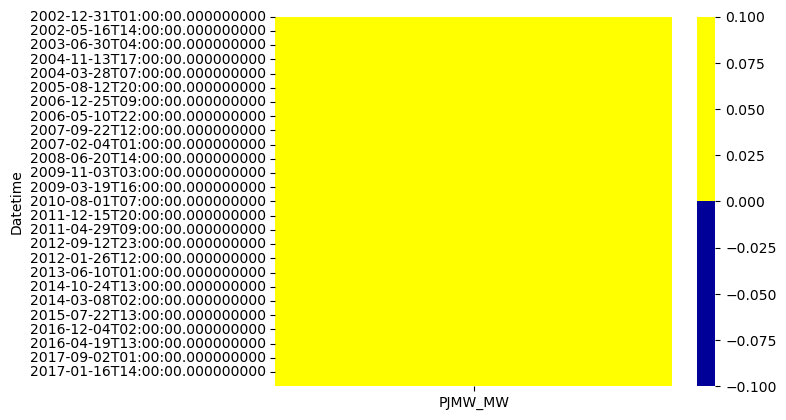

In [13]:
#heatmap for NA values
import seaborn as sns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is not missing. blue is missing.
sns.heatmap(data.isnull(),
            cmap = sns.color_palette(colours))
plt.show()

The dataset no any NA values so the heatmap is blank

In [14]:
# Sort the index in ascending order
data = data.sort_index(ascending=True)

# Print the sorted DataFrame
print(data.head())

                     PJMW_MW
Datetime                    
2002-04-01 01:00:00     4374
2002-04-01 02:00:00     4306
2002-04-01 03:00:00     4322
2002-04-01 04:00:00     4359
2002-04-01 05:00:00     4436


Sorted the dataset to arrange it in ascending order

In [15]:
data.tail()

PJMW_MW
Datetime                    
2018-08-02 20:00:00     6545
2018-08-02 21:00:00     6496
2018-08-02 22:00:00     6325
2018-08-02 23:00:00     5892
2018-08-03 00:00:00     5489

After sorting we found out that the data is from April 2002 to August 2018

In [16]:
data.index.year.unique()

Int64Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
            2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Datetime')

The dataset of PJM has given data from the year 2002 to 2018

In [17]:
data[data.index.duplicated()]

PJMW_MW
Datetime                    
2014-11-02 02:00:00     4613
2015-11-01 02:00:00     3832
2016-11-06 02:00:00     4089
2017-11-05 02:00:00     4042

In [18]:
unique, counts = np.unique(data.index.duplicated(), return_counts=True)
dict(zip(unique, counts))

{False: 143202, True: 4}

There are 4 Hours in the index that are duplicated in the data set

In [19]:
data['2014-11-02'].head()

PJMW_MW
Datetime                    
2014-11-02 00:00:00     4912
2014-11-02 01:00:00     4805
2014-11-02 02:00:00     4571
2014-11-02 02:00:00     4613
2014-11-02 03:00:00     4619

In [20]:
data=data.groupby(level=0).mean()

In [21]:
data['2014-11-02'].head()

PJMW_MW
Datetime                    
2014-11-02 00:00:00   4912.0
2014-11-02 01:00:00   4805.0
2014-11-02 02:00:00   4592.0
2014-11-02 03:00:00   4619.0
2014-11-02 04:00:00   4615.0

Replaced the duplicated indexes with the mean energy consumption values

In [22]:
pd.date_range(data.index.min(), data.index.max(), freq="y").difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [23]:
pd.date_range(data.index.min(), data.index.max(), freq="m").difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [24]:
pd.date_range(data.index.min(), data.index.max(), freq="d").difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [25]:
pd.date_range(data.index.min(), data.index.max(), freq="H").difference(data.index)

DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

There are no missing years or date but there are 30 missing hours for the dataset. So we have deal with it.

In [26]:
data['2002-04-07'].head()

PJMW_MW
Datetime                    
2002-04-07 00:00:00   5116.0
2002-04-07 01:00:00   5002.0
2002-04-07 02:00:00   4858.0
2002-04-07 04:00:00   4871.0
2002-04-07 05:00:00   4909.0

In [27]:
new_date_range = pd.date_range(data.index.min(), data.index.max(), freq="H")
data=data.reindex(new_date_range)
data.head(100)

PJMW_MW
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
...                      ...
2002-04-05 00:00:00   5266.0
2002-04-05 01:00:00   5140.0
2002-04-05 02:00:00   5045.0
2002-04-05 03:00:00   5027.0
2002-04-05 04:00:00   5062.0

[100 rows x 1 columns]

In [28]:
data['PJMW_MW']=data.PJMW_MW.interpolate(method='linear')
data.head(150)

PJMW_MW
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
...                      ...
2002-04-07 02:00:00   4858.0
2002-04-07 03:00:00   4864.5
2002-04-07 04:00:00   4871.0
2002-04-07 05:00:00   4909.0
2002-04-07 06:00:00   5038.0

[150 rows x 1 columns]

The missing hours are added and imputed with the mean of the above and below power consumption values

In [29]:
data

PJMW_MW
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
...                      ...
2018-08-02 20:00:00   6545.0
2018-08-02 21:00:00   6496.0
2018-08-02 22:00:00   6325.0
2018-08-02 23:00:00   5892.0
2018-08-03 00:00:00   5489.0

[143232 rows x 1 columns]

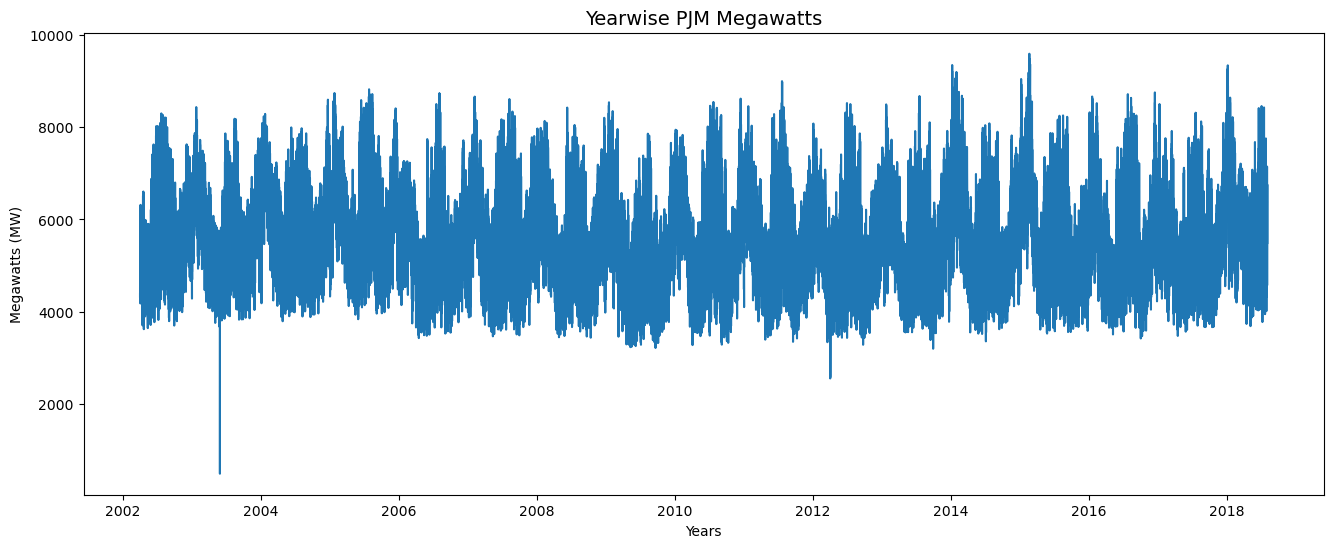

In [30]:
#line chart
plt.figure(figsize = (16, 6))
plt.plot(data['PJMW_MW']) 
plt.title('Yearwise PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('Years')
plt.ylabel('Megawatts (MW)')
plt.show()

Observations:
Though there is variation in the data i.e., there is peak point as well as low points, there is no any specific trend. It looks like a stationary series with constatnt mean and sd.
We can say that in one of the month of year 2003 there was an spike down in megawatt
The graph has multiplicative seasonality as the frequency varies
At some intervals' the peak is getting up and down which known as seasonality

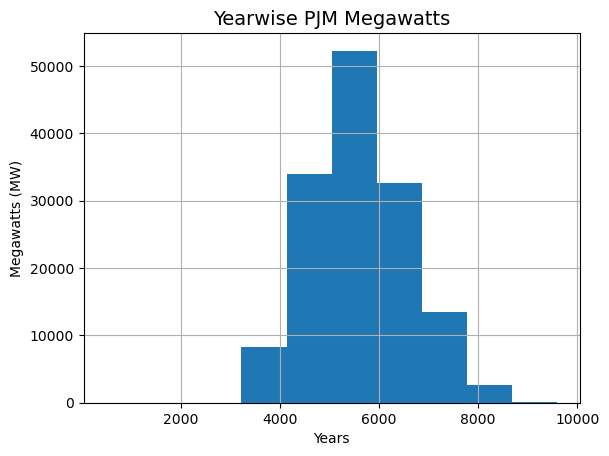

In [31]:
data.hist()
plt.title('Yearwise PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('Years')
plt.ylabel('Megawatts (MW)')
plt.show()

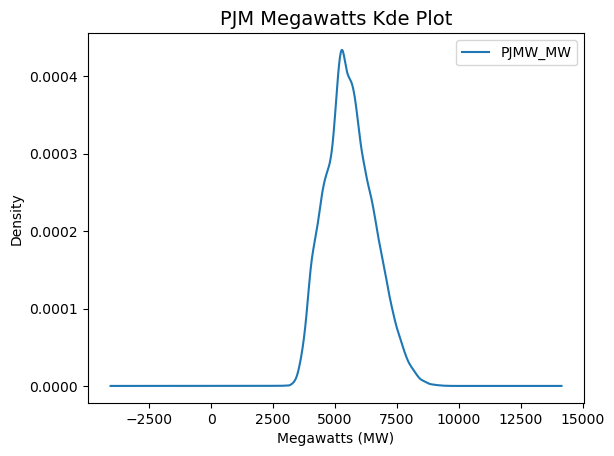

In [32]:
data.plot(kind='kde')
plt.title('PJM Megawatts Kde Plot',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('Megawatts (MW)')
plt.show()

#### Plot the maximum,minimum and mean values of each year

<AxesSubplot:>

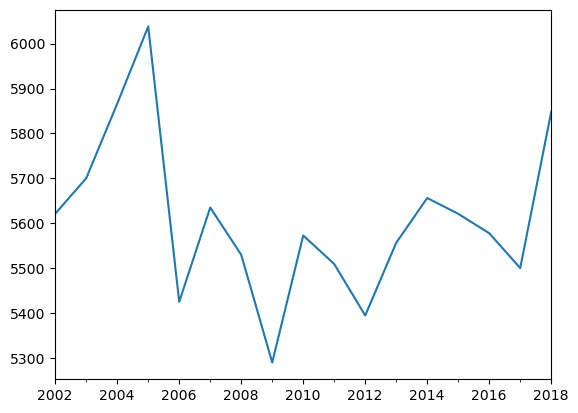

In [33]:
data.PJMW_MW.resample(rule='A').mean().plot()

<AxesSubplot:>

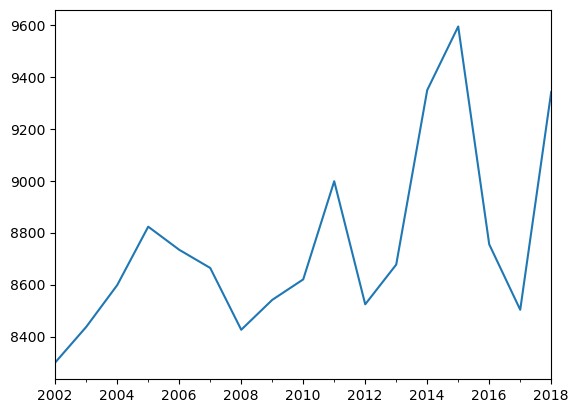

In [34]:
data.PJMW_MW.resample(rule='A').max().plot()

<AxesSubplot:>

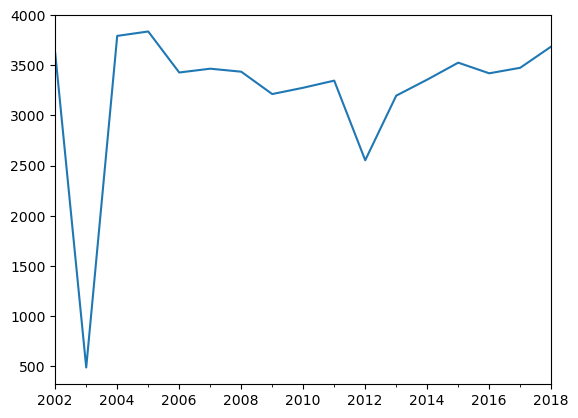

In [35]:
data.PJMW_MW.resample(rule='A').min().plot()

The minimum of 2003 seems to be an outlier.

In [36]:
data['2003'].PJMW_MW.resample(rule='A').min()

2003-12-31    487.0
Freq: A-DEC, Name: PJMW_MW, dtype: float64

In [37]:
data[data['PJMW_MW']==487.0]

PJMW_MW
2003-05-29    487.0

In [38]:
data['2003-05-29'].head()

PJMW_MW
2003-05-29 00:00:00    487.0
2003-05-29 01:00:00   4560.0
2003-05-29 02:00:00   4424.0
2003-05-29 03:00:00   4351.0
2003-05-29 04:00:00   4337.0

##### Replace the outlier value with the linear interpolation method

Interpolation is a technique for filling in missing values in a dataset based on the values of neighboring data points. Linear interpolation uses a straight line to estimate missing values based on the values of adjacent data points.

In [39]:
data['PJMW_MW'].mask(data['PJMW_MW']<500,inplace=True)

In [40]:
data['PJMW_MW']=data.PJMW_MW.interpolate(method='linear')

In [41]:
data['2003-05-29'].head()

PJMW_MW
2003-05-29 00:00:00   4938.5
2003-05-29 01:00:00   4560.0
2003-05-29 02:00:00   4424.0
2003-05-29 03:00:00   4351.0
2003-05-29 04:00:00   4337.0

Replaced the outlier value with the linear interpolation method

<AxesSubplot:>

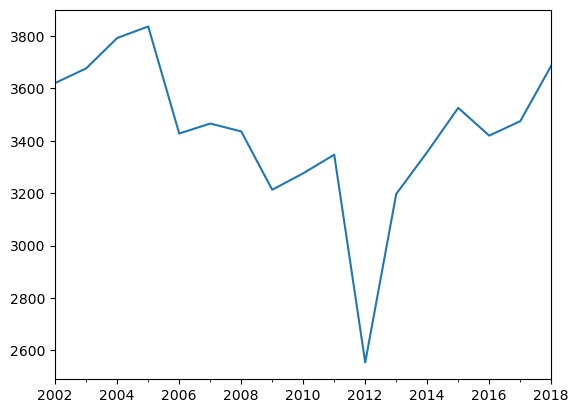

In [42]:
data.PJMW_MW.resample(rule='A').min().plot()

In [43]:
data[data['PJMW_MW']==2553.0]

PJMW_MW
2012-04-02   2553.0

In [44]:
data['2012-04-02'].head()

PJMW_MW
2012-04-02 00:00:00   2553.0
2012-04-02 01:00:00   3904.0
2012-04-02 02:00:00   3779.0
2012-04-02 03:00:00   3776.0
2012-04-02 04:00:00   3764.0

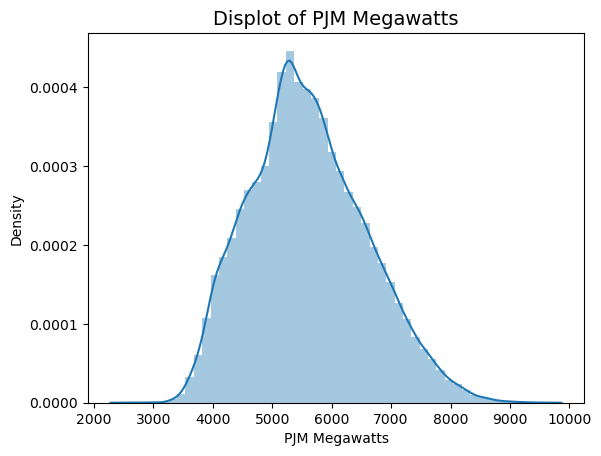

In [45]:
sns.distplot(data['PJMW_MW'])
plt.title('Displot of PJM Megawatts',fontdict={'fontsize': 14,'color': 'black'})
plt.xlabel('PJM Megawatts')
plt.show()

Observations: There is an showing nearly Normal distribution in graph The frequency of megawatts between 4000 to 6500 the variance is high At value nearlt 5100 the peak is high it is its mean value

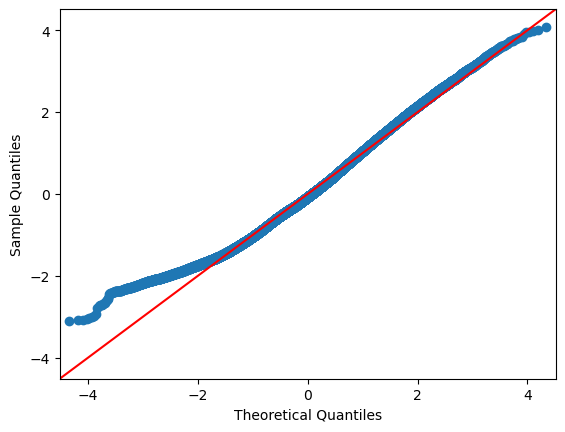

In [46]:
plot = sm.qqplot(data['PJMW_MW'],line = "45" , fit=True)

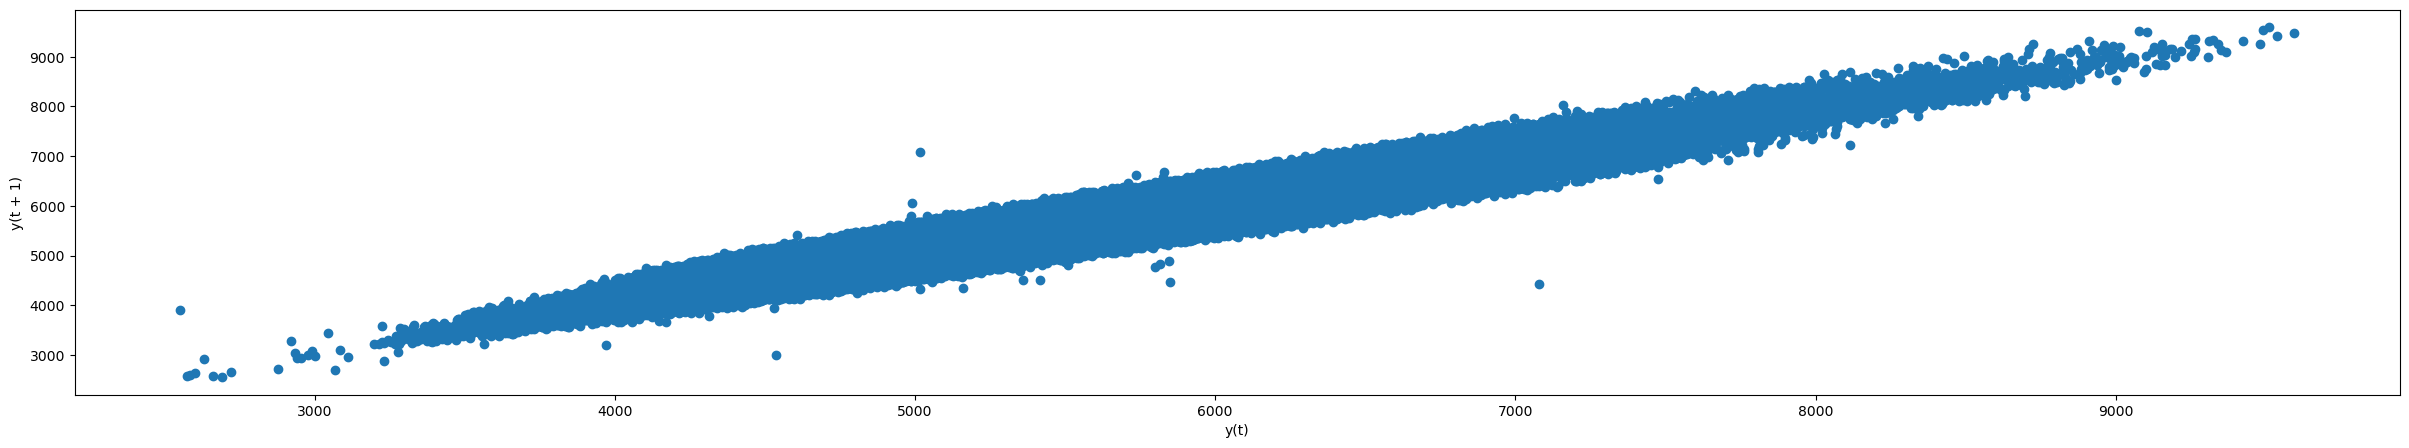

In [47]:
from pandas.plotting import lag_plot
plt.figure(figsize=(30,5))
lag_plot(data["PJMW_MW"])
plt.show()

This shows that the data are strongly non-random.It has an upward trend and positive correlation.

In [48]:
data.index

DatetimeIndex(['2002-04-01 01:00:00', '2002-04-01 02:00:00',
               '2002-04-01 03:00:00', '2002-04-01 04:00:00',
               '2002-04-01 05:00:00', '2002-04-01 06:00:00',
               '2002-04-01 07:00:00', '2002-04-01 08:00:00',
               '2002-04-01 09:00:00', '2002-04-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', length=143232, freq='H')

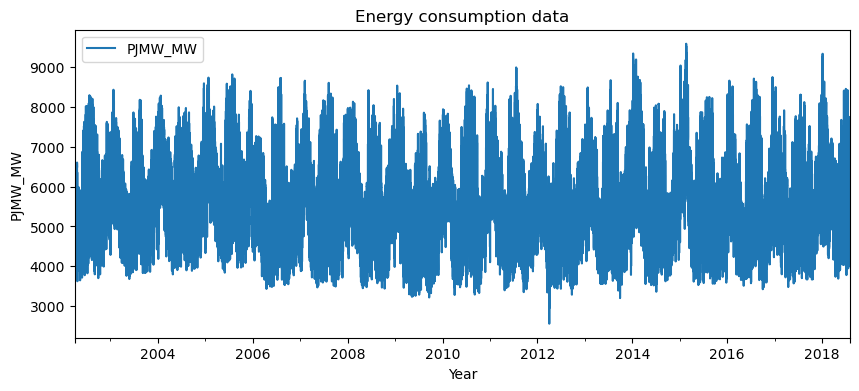

In [49]:
plt.rcParams["figure.figsize"]= (10,4)
data.plot()
plt.xlabel('Year') 
plt.ylabel('PJMW_MW') 
# displaying the title
plt.title("Energy consumption data")
plt.show()

In [50]:
data

PJMW_MW
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
...                      ...
2018-08-02 20:00:00   6545.0
2018-08-02 21:00:00   6496.0
2018-08-02 22:00:00   6325.0
2018-08-02 23:00:00   5892.0
2018-08-03 00:00:00   5489.0

[143232 rows x 1 columns]

In [51]:
df=data.copy()

In [52]:
df

PJMW_MW
2002-04-01 01:00:00   4374.0
2002-04-01 02:00:00   4306.0
2002-04-01 03:00:00   4322.0
2002-04-01 04:00:00   4359.0
2002-04-01 05:00:00   4436.0
...                      ...
2018-08-02 20:00:00   6545.0
2018-08-02 21:00:00   6496.0
2018-08-02 22:00:00   6325.0
2018-08-02 23:00:00   5892.0
2018-08-03 00:00:00   5489.0

[143232 rows x 1 columns]

In [53]:
df["Date"] = pd.to_datetime(df.index,format='%Y-%m-%d %H:%M')

# Extracting Day, month name, year from the Datetime column using Date functions from pandas 

df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df["day"] = df.Date.dt.strftime("%d") # day extraction
df["Hour"] = df.Date.dt.strftime("%H") # Hour extraction
df['weekday_name'] = pd.to_datetime(df.index).day_name()

In [54]:
df

PJMW_MW                Date month  year day Hour  \
2002-04-01 01:00:00   4374.0 2002-04-01 01:00:00   Apr  2002  01   01   
2002-04-01 02:00:00   4306.0 2002-04-01 02:00:00   Apr  2002  01   02   
2002-04-01 03:00:00   4322.0 2002-04-01 03:00:00   Apr  2002  01   03   
2002-04-01 04:00:00   4359.0 2002-04-01 04:00:00   Apr  2002  01   04   
2002-04-01 05:00:00   4436.0 2002-04-01 05:00:00   Apr  2002  01   05   
...                      ...                 ...   ...   ...  ..  ...   
2018-08-02 20:00:00   6545.0 2018-08-02 20:00:00   Aug  2018  02   20   
2018-08-02 21:00:00   6496.0 2018-08-02 21:00:00   Aug  2018  02   21   
2018-08-02 22:00:00   6325.0 2018-08-02 22:00:00   Aug  2018  02   22   
2018-08-02 23:00:00   5892.0 2018-08-02 23:00:00   Aug  2018  02   23   
2018-08-03 00:00:00   5489.0 2018-08-03 00:00:00   Aug  2018  03   00   

                    weekday_name  
2002-04-01 01:00:00       Monday  
2002-04-01 02:00:00       Monday  
2002-04-01 03:00:00       Monday  
2002-04-01 04:00:00       Monday  
2002-04-01 05:00:00       Monday  
...                          ...  
2018-08-02 20:00:00     Thursday  
2018-08-02 21:00:00     Thursday  
2018-08-02 22:00:00     Thursday  
2018-08-02 23:00:00     Thursday  
2018-08-03 00:00:00       Friday  

[143232 rows x 7 columns]

In [55]:
df.drop('Date',axis=1,inplace=True)

In [56]:
df

PJMW_MW month  year day Hour weekday_name
2002-04-01 01:00:00   4374.0   Apr  2002  01   01       Monday
2002-04-01 02:00:00   4306.0   Apr  2002  01   02       Monday
2002-04-01 03:00:00   4322.0   Apr  2002  01   03       Monday
2002-04-01 04:00:00   4359.0   Apr  2002  01   04       Monday
2002-04-01 05:00:00   4436.0   Apr  2002  01   05       Monday
...                      ...   ...   ...  ..  ...          ...
2018-08-02 20:00:00   6545.0   Aug  2018  02   20     Thursday
2018-08-02 21:00:00   6496.0   Aug  2018  02   21     Thursday
2018-08-02 22:00:00   6325.0   Aug  2018  02   22     Thursday
2018-08-02 23:00:00   5892.0   Aug  2018  02   23     Thursday
2018-08-03 00:00:00   5489.0   Aug  2018  03   00       Friday

[143232 rows x 6 columns]

### year wise trend

<AxesSubplot:>

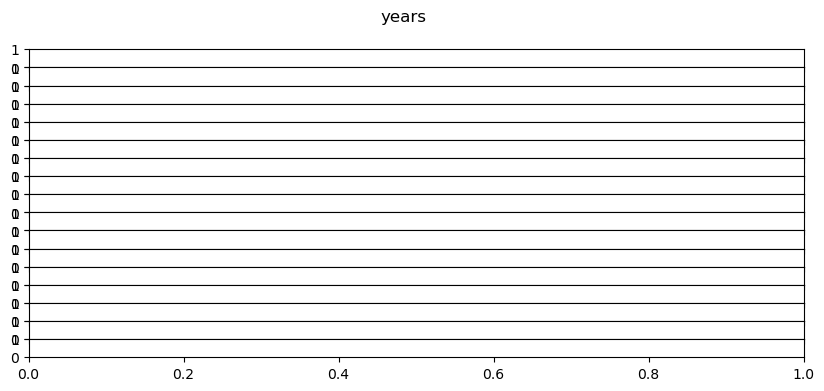

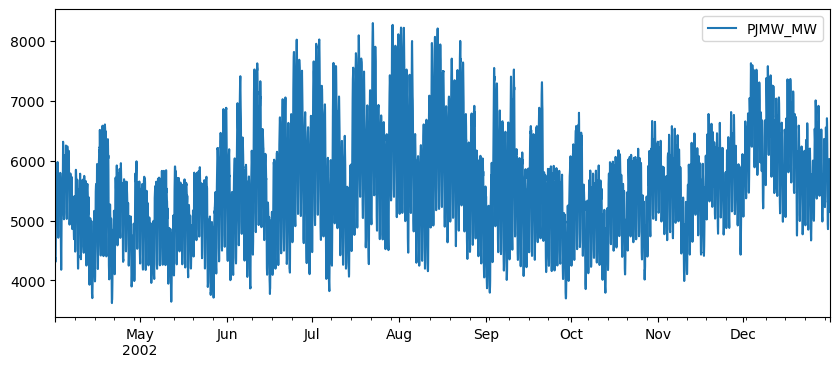

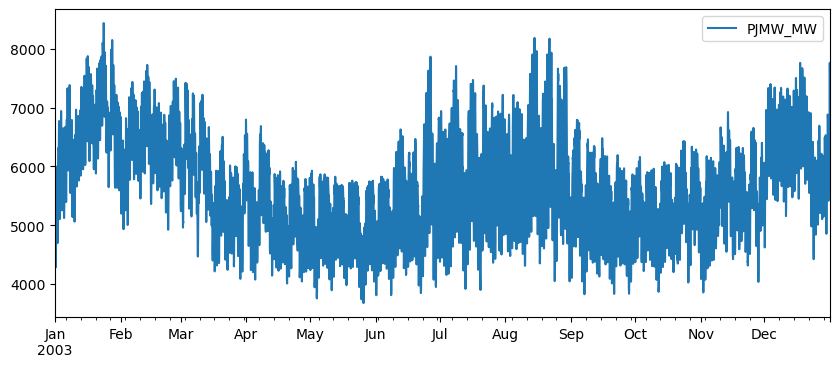

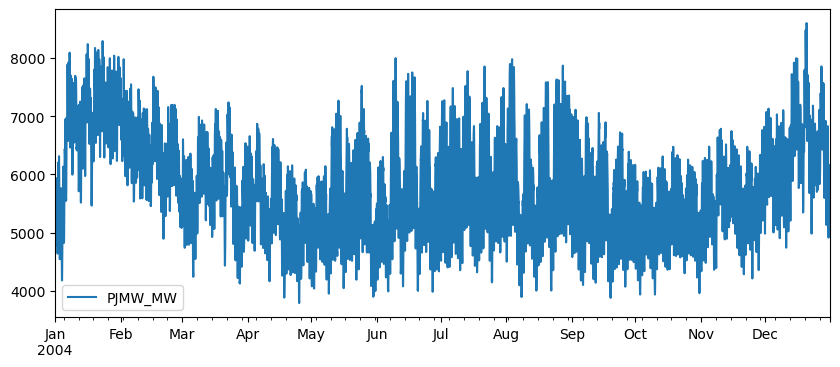

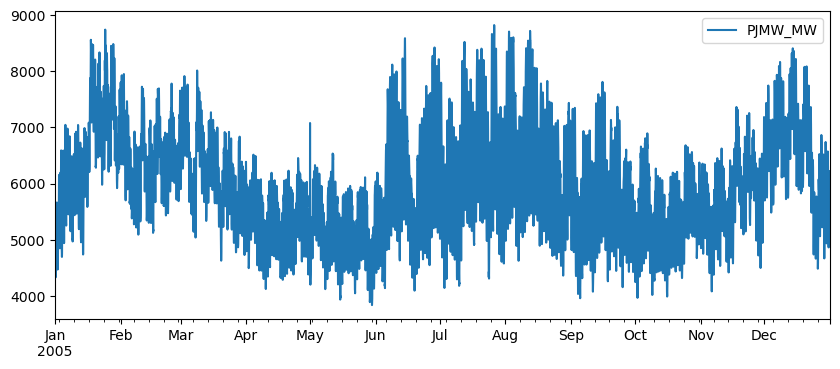

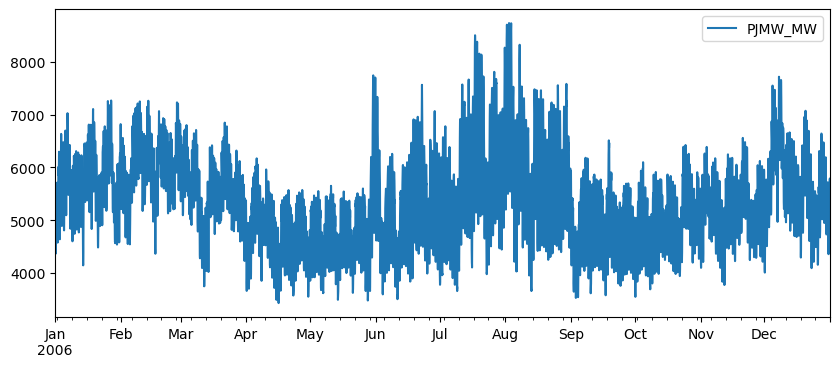

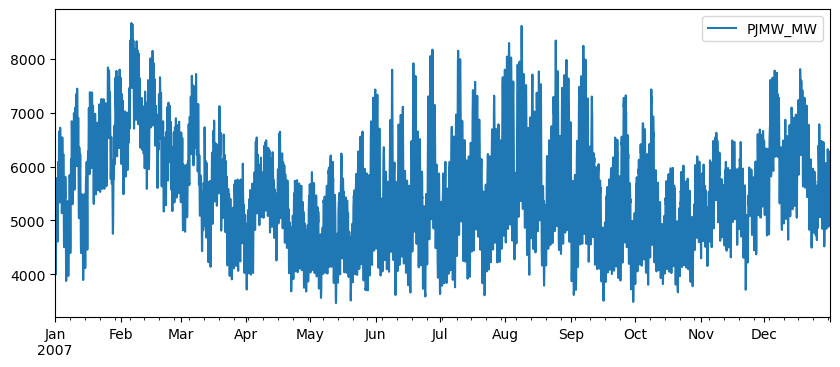

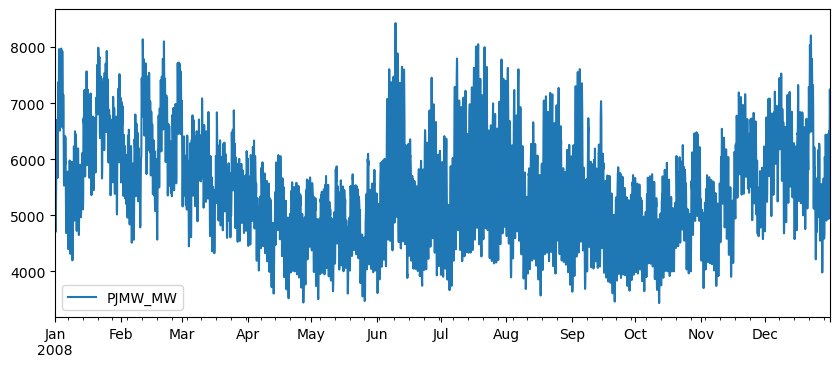

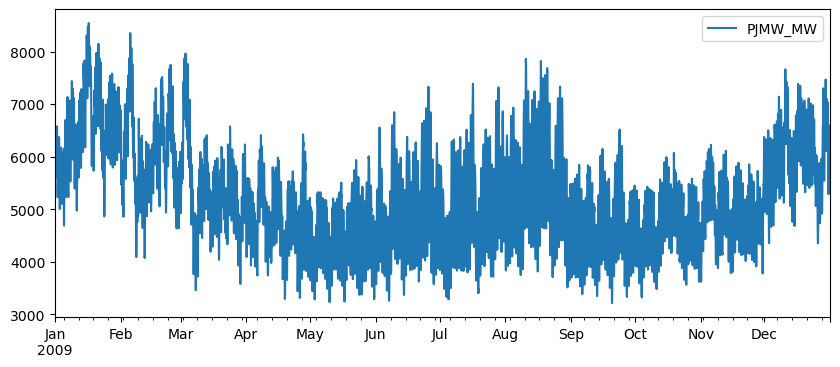

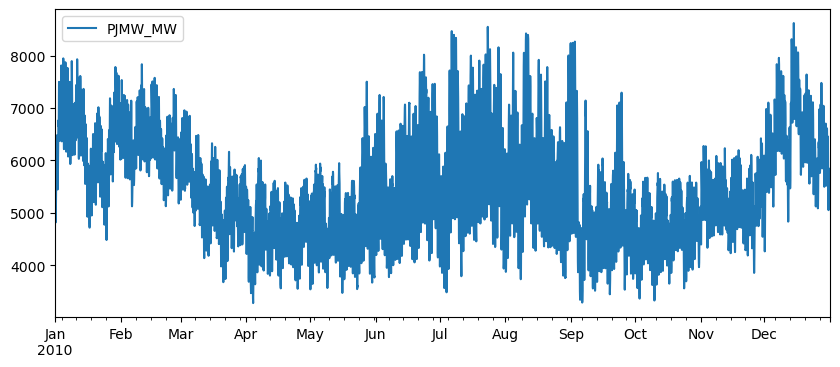

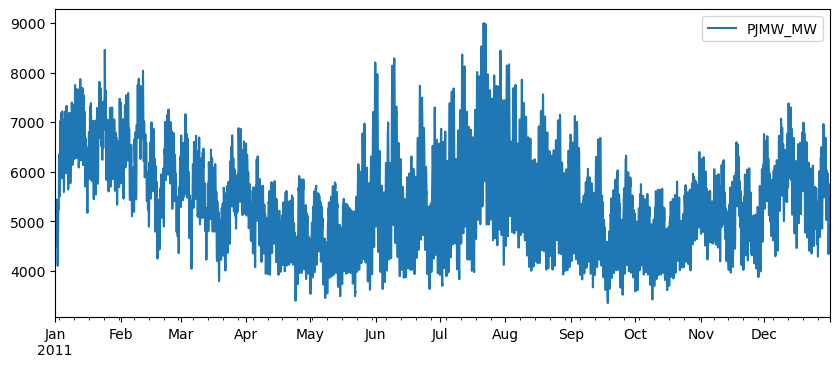

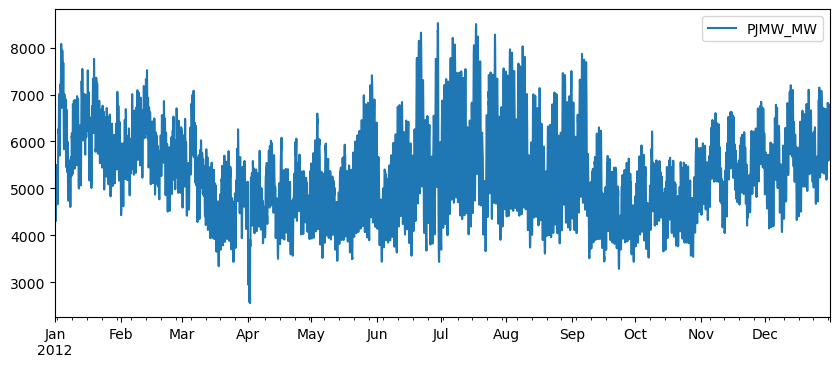

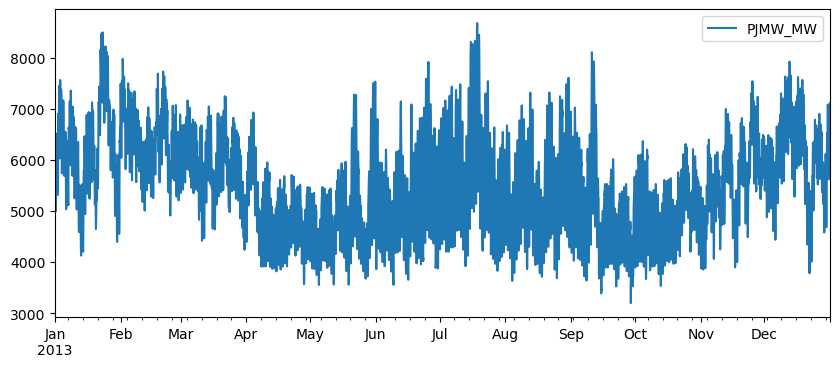

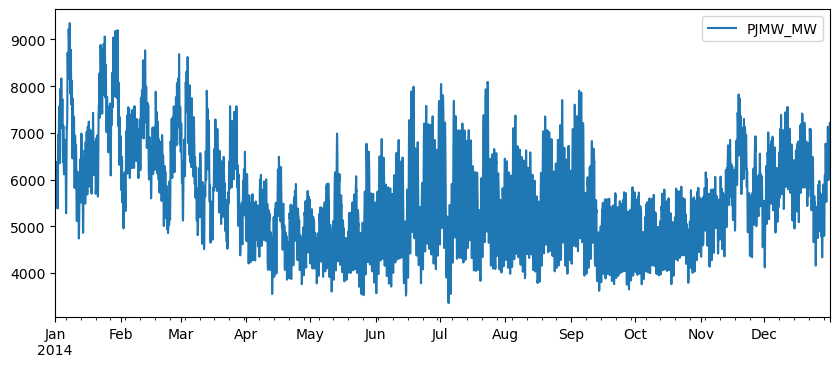

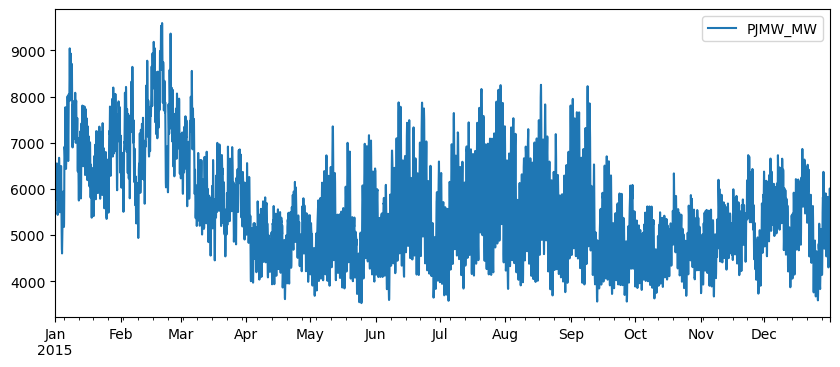

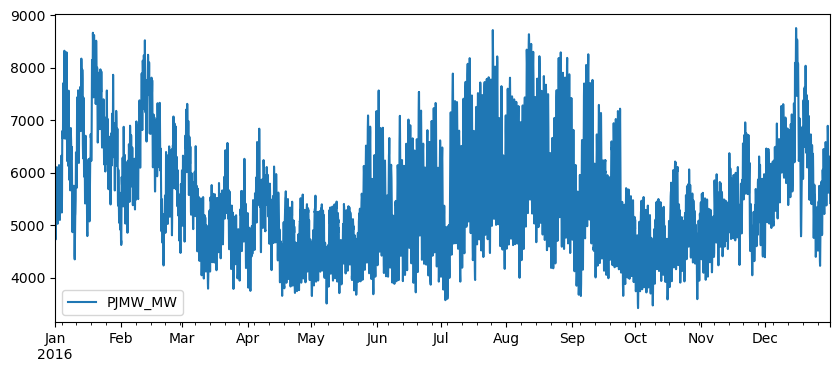

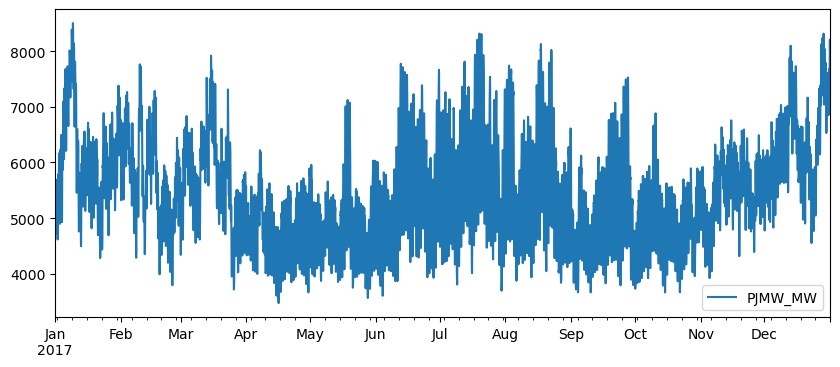

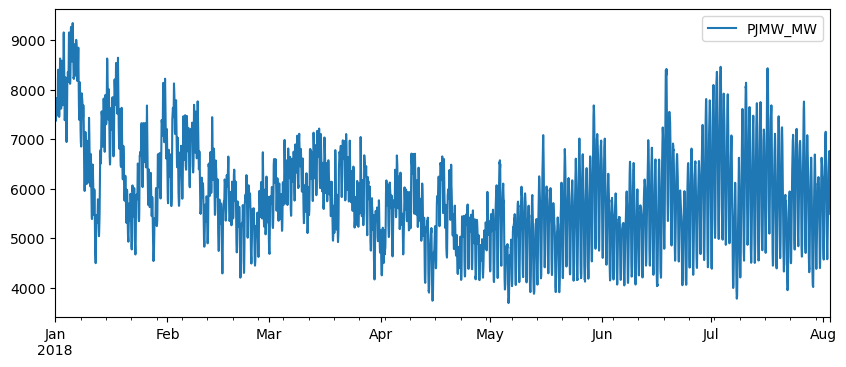

In [57]:
fig = plt.figure()
gs = fig.add_gridspec(17, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('years')
df.loc['2002'].plot()
df.loc['2003'].plot()
df.loc['2004'].plot()
df.loc['2005'].plot()
df.loc['2006'].plot()
df.loc['2007'].plot()
df.loc['2008'].plot()
df.loc['2009'].plot()
df.loc['2010'].plot()
df.loc['2011'].plot()
df.loc['2012'].plot()
df.loc['2013'].plot()
df.loc['2014'].plot()
df.loc['2015'].plot()
df.loc['2016'].plot()
df.loc['2017'].plot()
df.loc['2018'].plot()

Text(0.5, 1.0, 'Yearly trend')

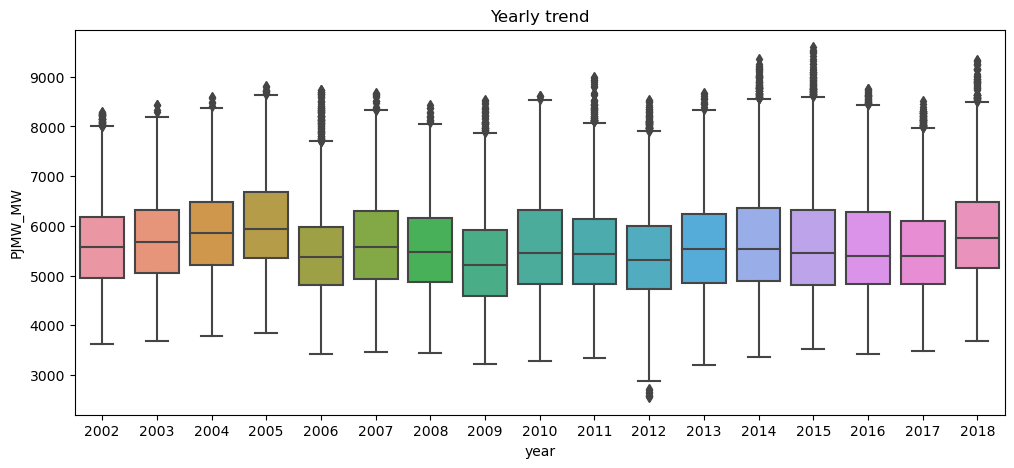

In [58]:
### Boxplot Visualization
## checking yearly trend
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.year,
                y = df['PJMW_MW'], 
                ax = ax)
ax.set_title('Yearly trend')

Observations: The energy consumed in the year 2005 has highest megawatt power used Whereas, in the year 2009 less energy was consumed There are gradually ups and downs in the energy consumption

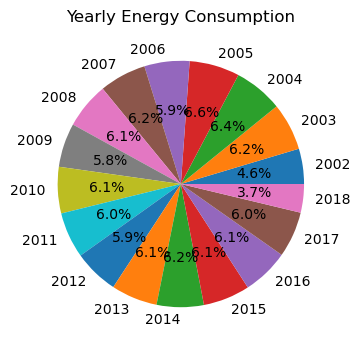

In [59]:
# Group by year and sum energy consumption
yearly_energy = df.groupby('year')['PJMW_MW'].sum()

# Create pie chart
yearly_energy.plot(kind='pie', title='Yearly Energy Consumption', autopct='%1.1f%%', ylabel='')
plt.show()

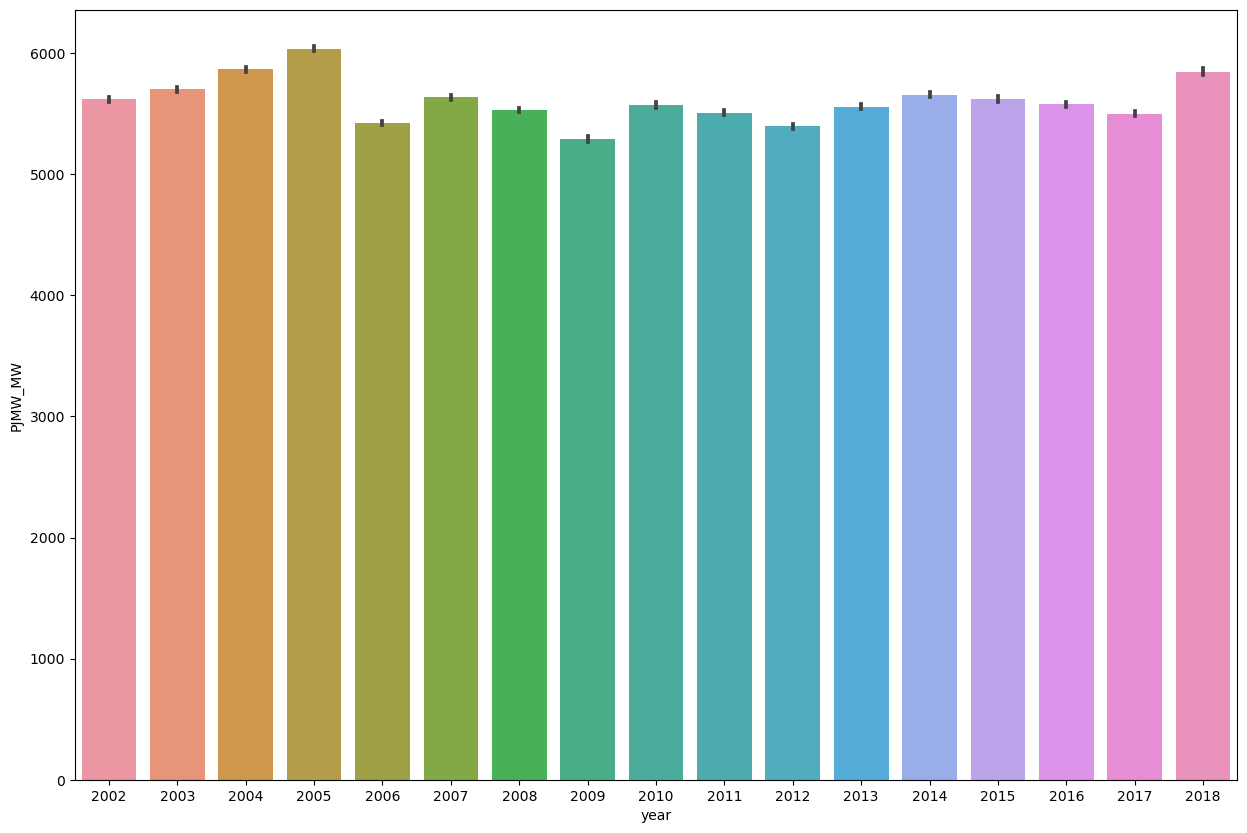

In [60]:
#bar plot 
plt.figure(figsize=(15,10))
sns.barplot(x='year',y='PJMW_MW',data=df)
plt.show()

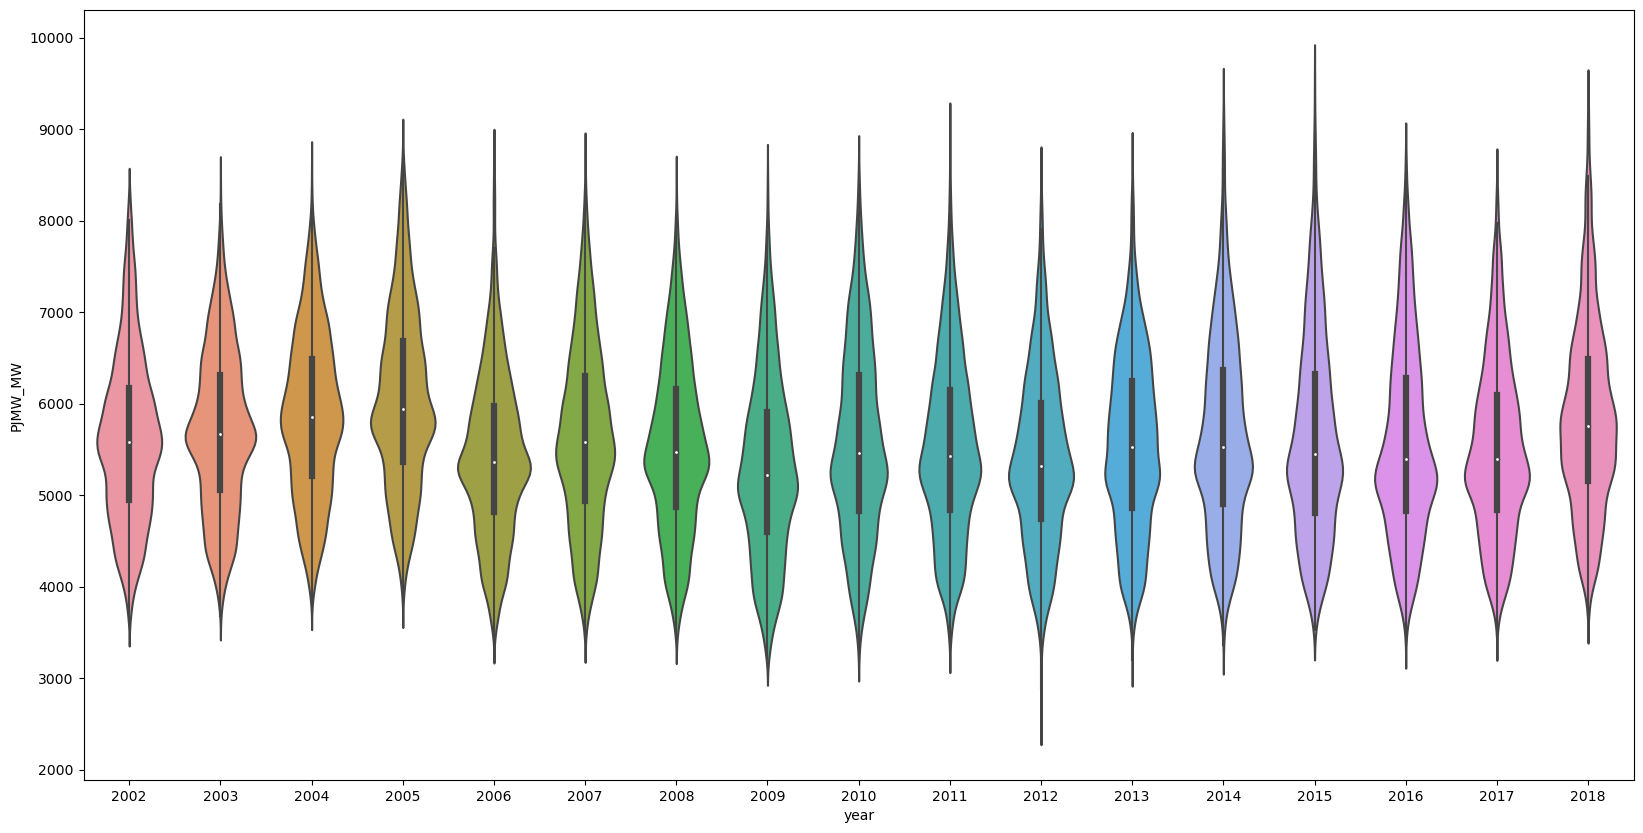

In [61]:
#violin plot
plt.figure(figsize=(20,10))
sns.violinplot(data=df , x="year", y="PJMW_MW",bw=.15)
plt.show()

Observation: Low consumption in 2002 and high consumption in 2005

Text(0.5, 1.0, 'Monthly trend')

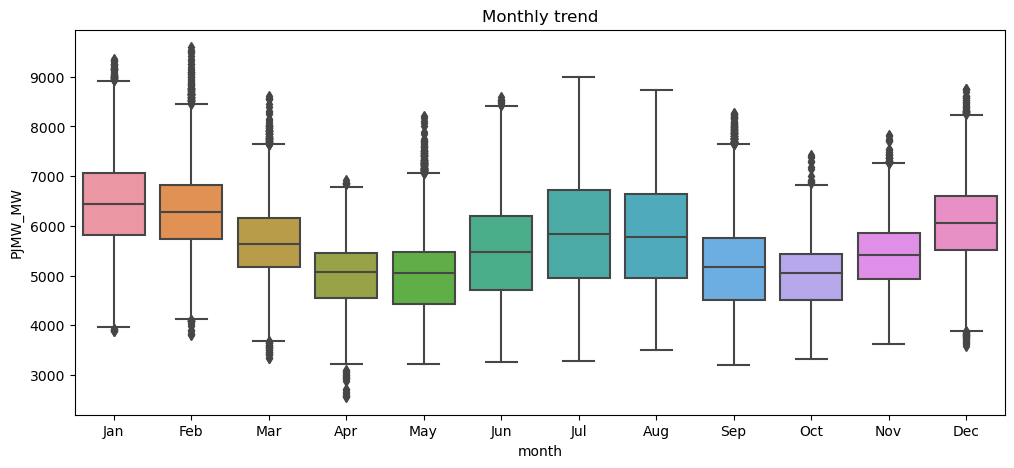

In [62]:
### Check for the monthly trend
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.month,
                y = df['PJMW_MW'], order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                ax = ax)
ax.set_title('Monthly trend')

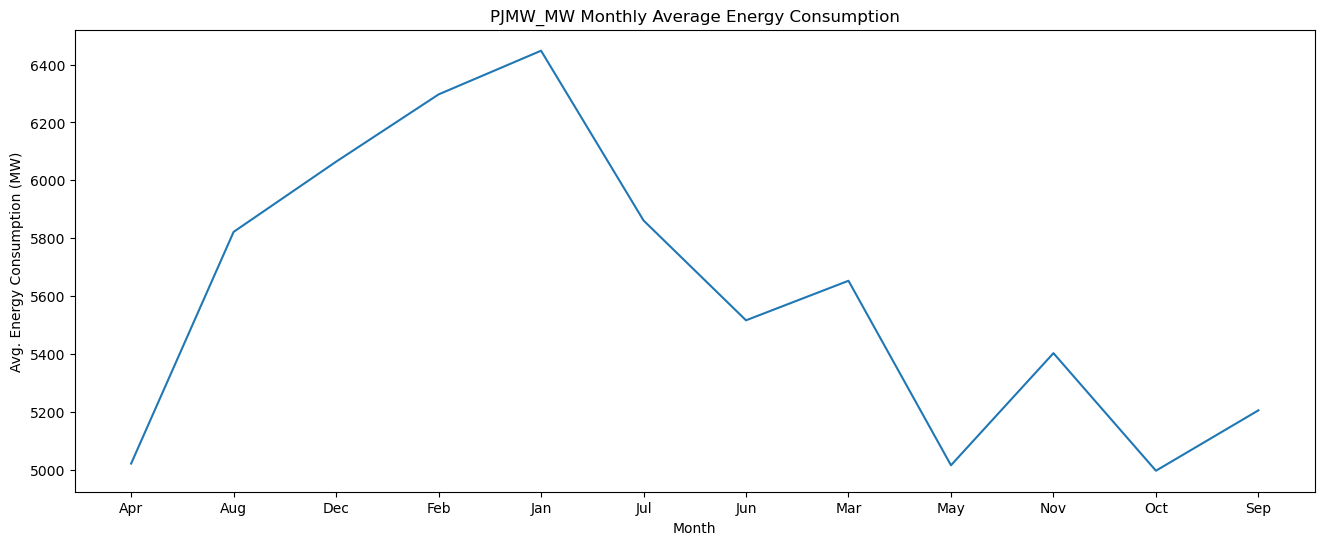

In [63]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df.groupby('month').mean(),x='month',y='PJMW_MW')
plt.title('PJMW_MW Monthly Average Energy Consumption', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

Observation: For Dec, Jan, Feb and Jun,Jul, Aug the consumptin is higher as compared to other months.

### Create the column 'Season' to Check for the seasonal trend

In [64]:
df['season']=df['month'].copy()
df['season']=df['season'].map({'Jan':'Winter','Feb':'Winter','Mar':'Winter','Apr':'Spring','May':'Spring','Jun':'Spring','Aug':'Summer','Sep':'Summer','Jul':'Summer','Oct': 'Fall','Nov': 'Fall','Dec': 'Fall'})
df.head()

PJMW_MW month  year day Hour weekday_name  season
2002-04-01 01:00:00   4374.0   Apr  2002  01   01       Monday  Spring
2002-04-01 02:00:00   4306.0   Apr  2002  01   02       Monday  Spring
2002-04-01 03:00:00   4322.0   Apr  2002  01   03       Monday  Spring
2002-04-01 04:00:00   4359.0   Apr  2002  01   04       Monday  Spring
2002-04-01 05:00:00   4436.0   Apr  2002  01   05       Monday  Spring

<AxesSubplot:xlabel='year', ylabel='PJMW_MW'>

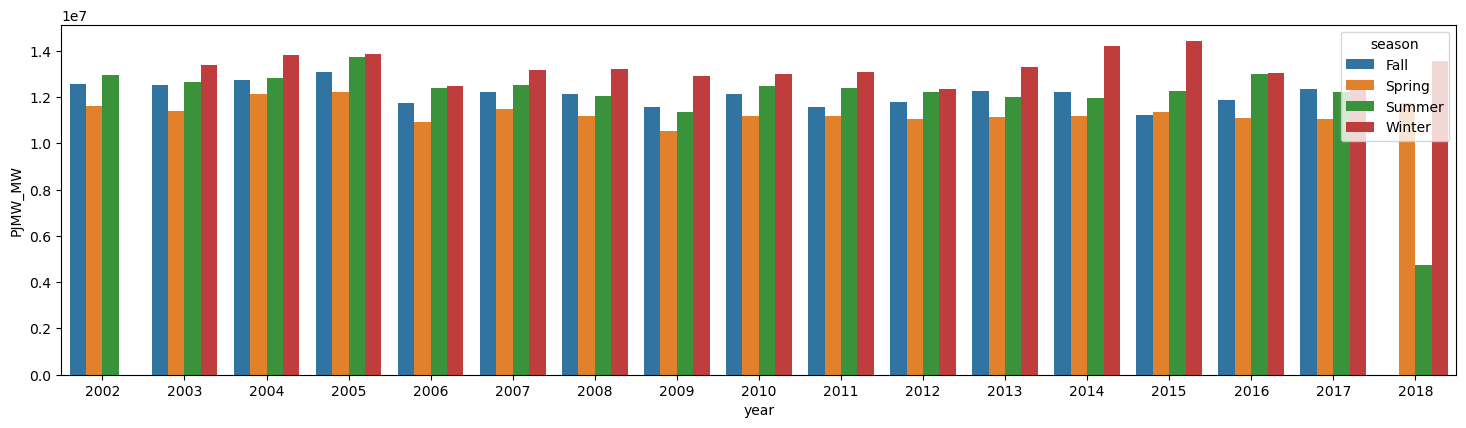

In [65]:
plt.figure(figsize=(18,10))
aux1 = df[['year', 'season', 'PJMW_MW']].groupby( ['year', 'season'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='season', data=aux1 )

Observation: For winter season the energy consumption is on a higher side and for spring the consumption is comparatively low

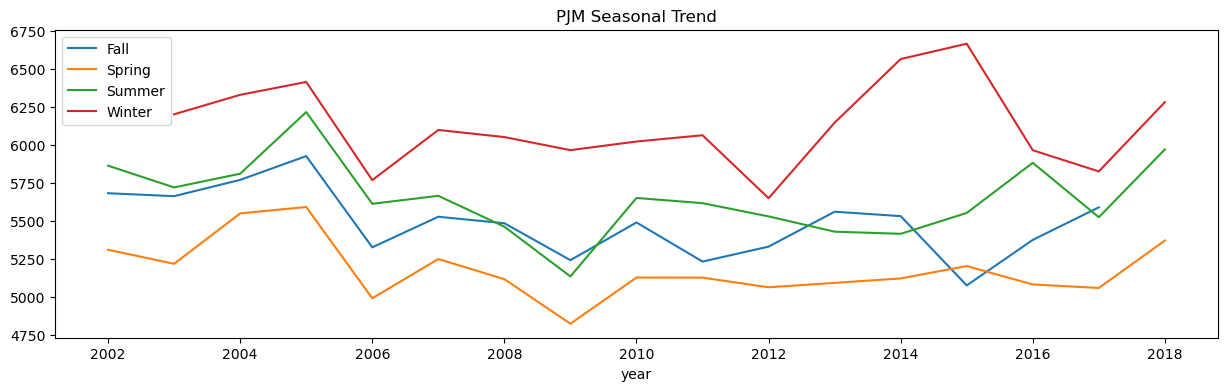

In [66]:
df.pivot_table(index=df['year'], 
                     columns='season', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM Seasonal Trend')
plt.legend(loc='upper left')

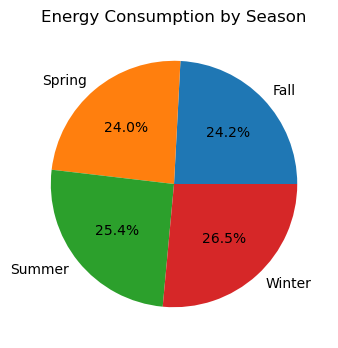

In [67]:
seasonal_energy = df.groupby('season')['PJMW_MW'].sum()

# Create pie chart
seasonal_energy.plot(kind='pie', title='Energy Consumption by Season', autopct='%1.1f%%', ylabel='')
plt.show()

<AxesSubplot:xlabel='season', ylabel='PJMW_MW'>

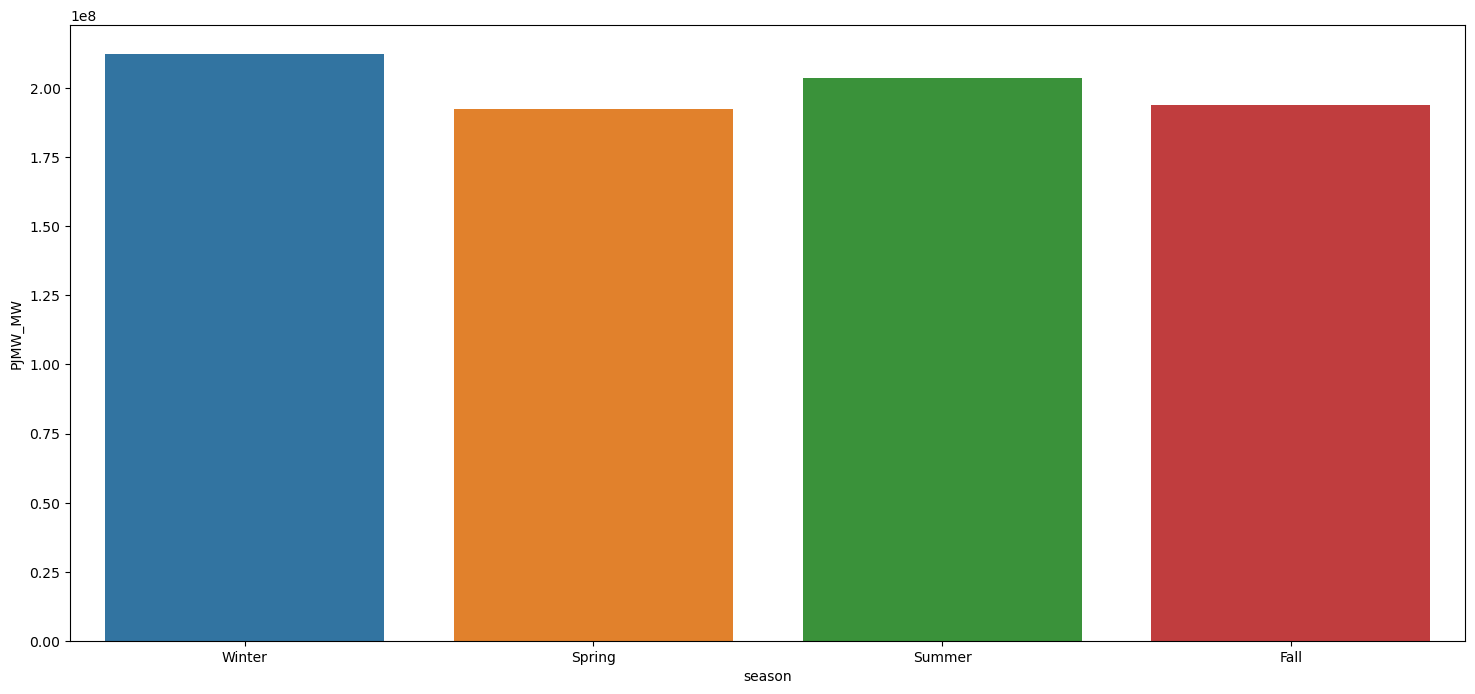

In [68]:
plt.figure(figsize=(18,8))
aux1 = df[['season', 'PJMW_MW']].groupby( 'season' ).sum().reset_index()
sns.barplot( x='season', y='PJMW_MW', data=aux1, order=['Winter', 'Spring', 'Summer', 'Fall'] )


Observation: For winter season the energy consumption is on a higher side and for spring the consumption is comparatively low

<AxesSubplot:xlabel='month', ylabel='year'>

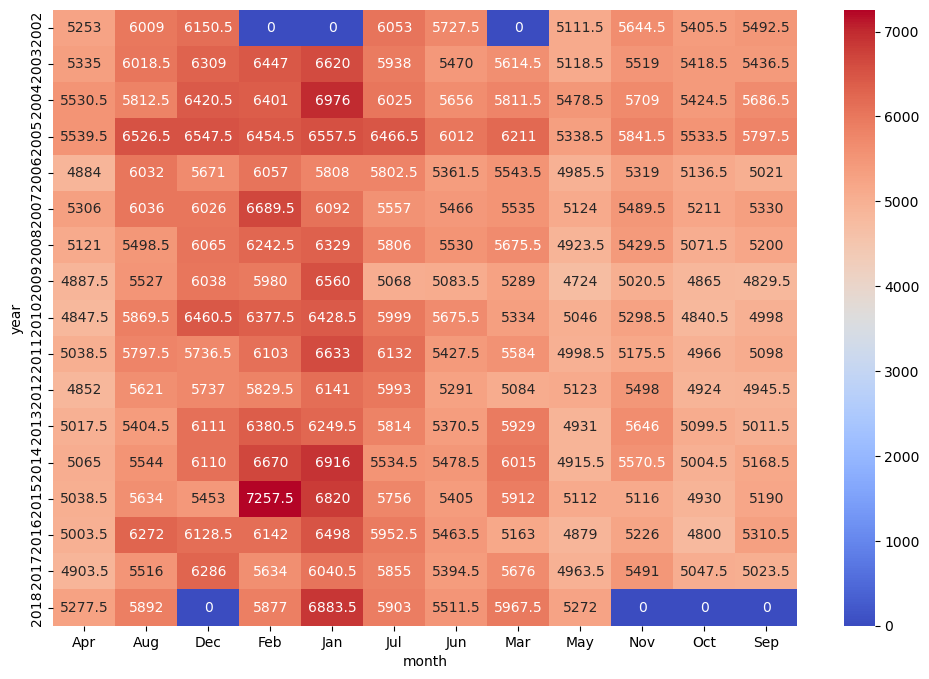

In [69]:
plt.figure(figsize=(12,8))
heatmap = pd.pivot_table(data=df, values="PJMW_MW", index="year", columns="month", aggfunc="median", fill_value=0)
sns.heatmap(heatmap, fmt="g", annot=True, cmap="coolwarm")

## Hour wise trend

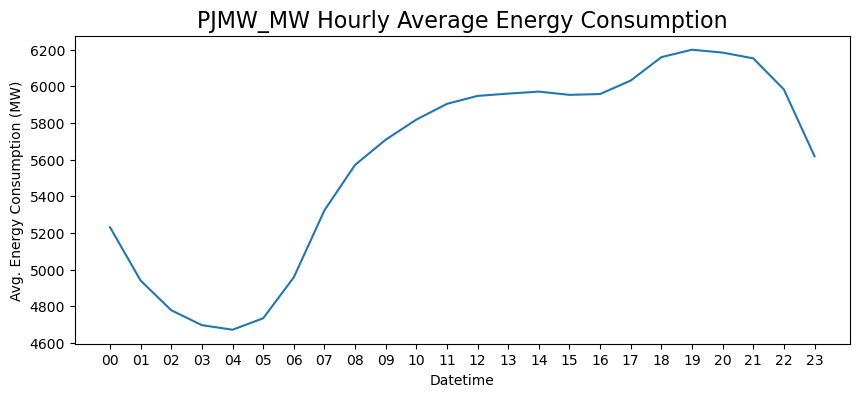

In [70]:
sns.lineplot(data=df.groupby('Hour').mean(),x='Hour',y='PJMW_MW')
plt.title('PJMW_MW Hourly Average Energy Consumption', fontsize=16)
plt.xlabel('Datetime')
plt.ylabel('Avg. Energy Consumption (MW)')
plt.show()

Text(0.5, 1.0, 'Daily trend - Hourly basis')

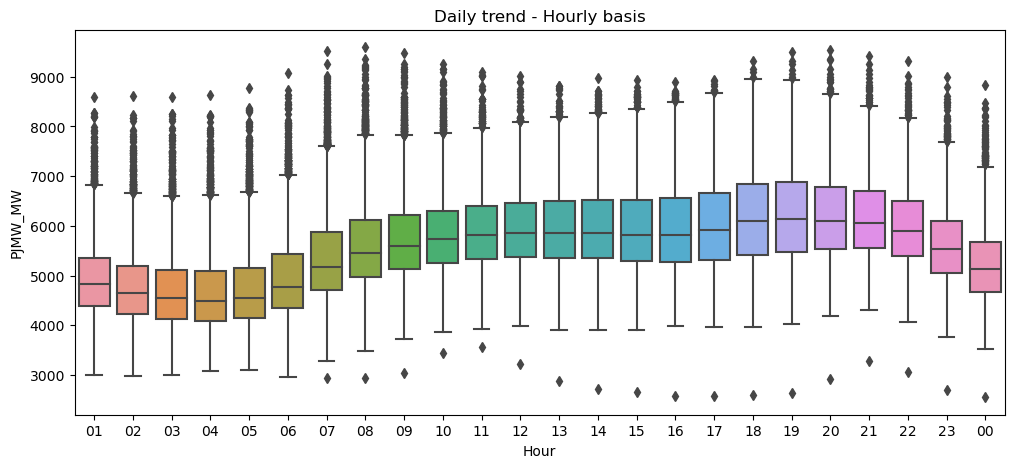

In [71]:
### Check for the hourly trend
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.Hour,
                y = df['PJMW_MW'], 
                ax = ax)
ax.set_title('Daily trend - Hourly basis')

Observation: From midnight after 10 pm the power consumption starts decreasing and from morning 7 it increases till 10 pm.

<AxesSubplot:xlabel='day', ylabel='PJMW_MW'>

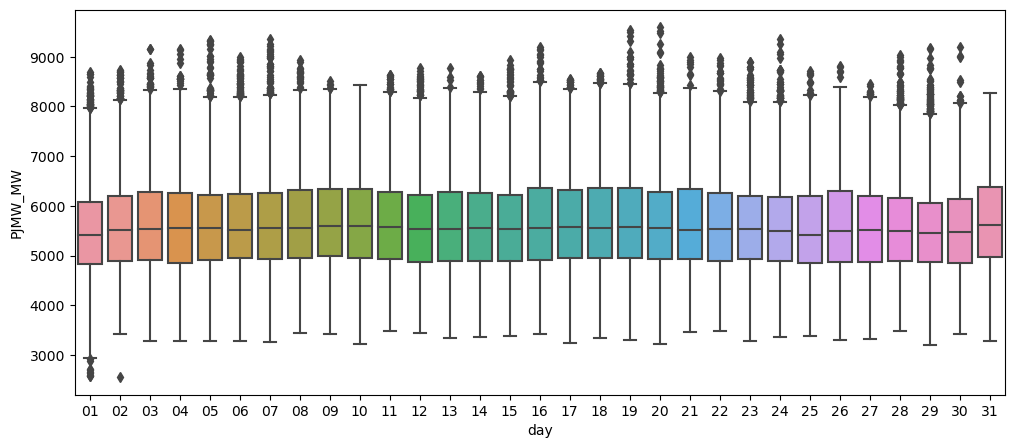

In [72]:
## Check for the daily trend
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.day,
                y = df['PJMW_MW'],
                ax = ax)

<AxesSubplot:xlabel='weekday_name', ylabel='PJMW_MW'>

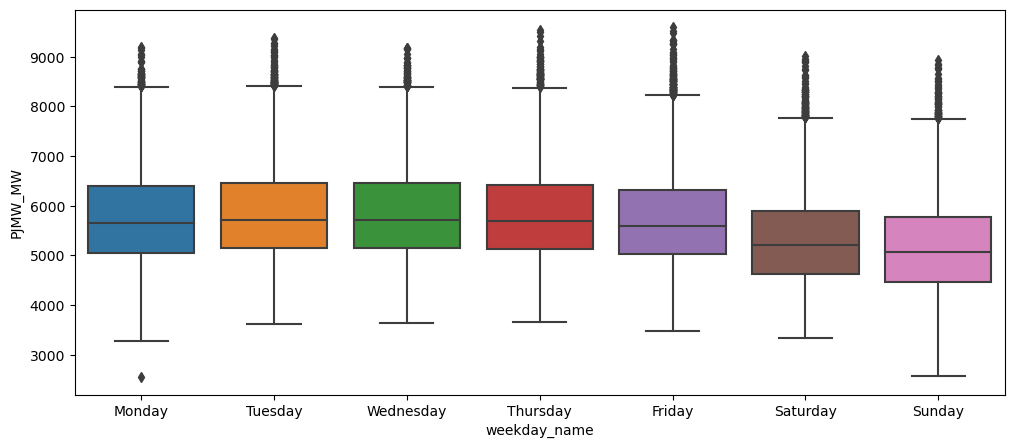

In [73]:
###Check for the Weekly trend
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = df.weekday_name,
                y = df['PJMW_MW'],order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                ax = ax)

Observation:Low power consumption during Weekends

## Weekday and weekend trend 

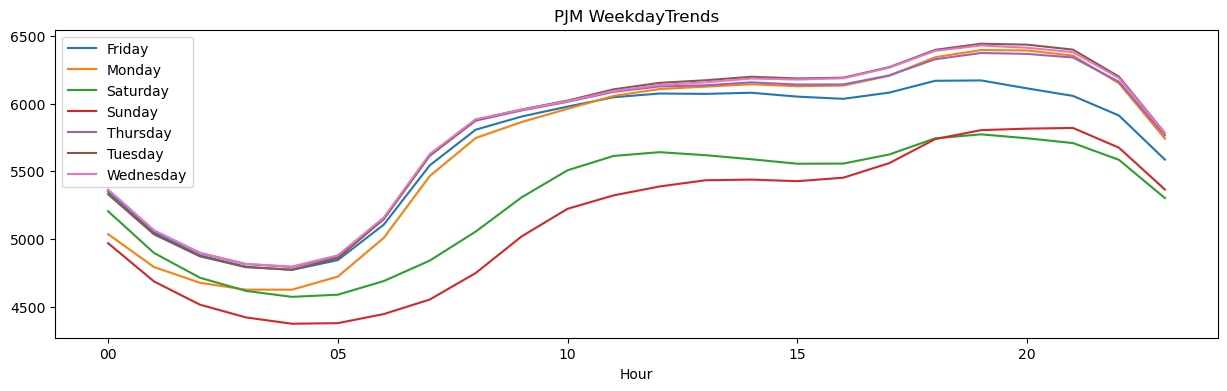

In [74]:
df.pivot_table(index=df['Hour'], 
                     columns='weekday_name', 
                     values='PJMW_MW',
                     aggfunc='mean').plot(figsize=(15,4),
                     title='PJM WeekdayTrends')
plt.legend(loc='upper left')

Observation: The plot shows that there are less consumption of power during weekends as compared to weekdays. Also the power consumption began to rise from morning 7 and at midnight 10 it again decreases.

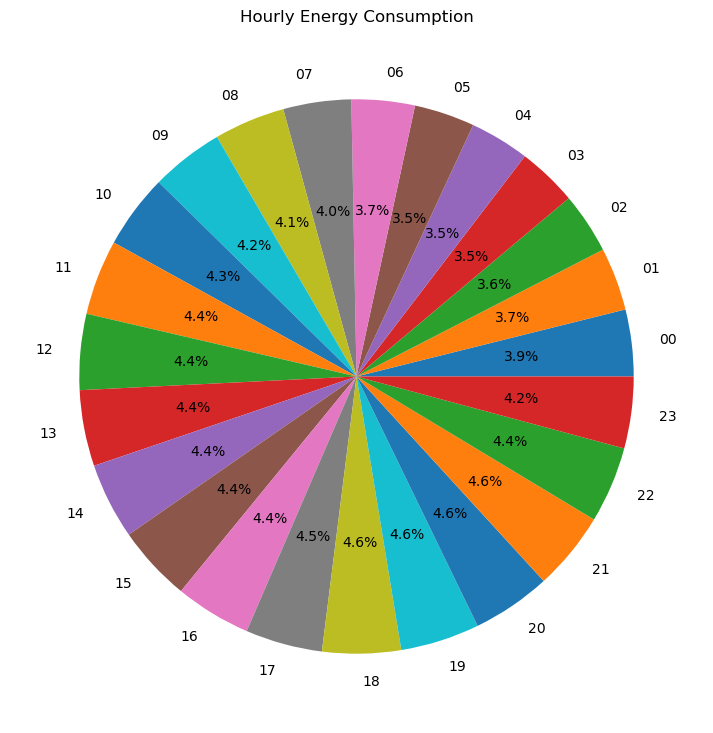

In [75]:
# Group by hour and sum energy consumption
yearly_energy = df.groupby('Hour')['PJMW_MW'].sum()

# Create pie chart
yearly_energy.plot(kind='pie', title='Hourly Energy Consumption', autopct='%1.1f%%', ylabel='',figsize=(9,9))
plt.show()

In [76]:
df['date'] = df.index.date
df=df.reset_index()

In [77]:
df

index  PJMW_MW month  year day Hour weekday_name  season  \
0      2002-04-01 01:00:00   4374.0   Apr  2002  01   01       Monday  Spring   
1      2002-04-01 02:00:00   4306.0   Apr  2002  01   02       Monday  Spring   
2      2002-04-01 03:00:00   4322.0   Apr  2002  01   03       Monday  Spring   
3      2002-04-01 04:00:00   4359.0   Apr  2002  01   04       Monday  Spring   
4      2002-04-01 05:00:00   4436.0   Apr  2002  01   05       Monday  Spring   
...                    ...      ...   ...   ...  ..  ...          ...     ...   
143227 2018-08-02 20:00:00   6545.0   Aug  2018  02   20     Thursday  Summer   
143228 2018-08-02 21:00:00   6496.0   Aug  2018  02   21     Thursday  Summer   
143229 2018-08-02 22:00:00   6325.0   Aug  2018  02   22     Thursday  Summer   
143230 2018-08-02 23:00:00   5892.0   Aug  2018  02   23     Thursday  Summer   
143231 2018-08-03 00:00:00   5489.0   Aug  2018  03   00       Friday  Summer   

              date  
0       2002-04-01  
1       2002-04-01  
2       2002-04-01  
3       2002-04-01  
4       2002-04-01  
...            ...  
143227  2018-08-02  
143228  2018-08-02  
143229  2018-08-02  
143230  2018-08-02  
143231  2018-08-03  

[143232 rows x 9 columns]

### Check for the Holiday trend

In [89]:
import holidays

In [90]:
df['holidays'] = df.date.apply( lambda x: 'Holiday' if x in holidays.US() else 'Normal day' )

<AxesSubplot:xlabel='year', ylabel='PJMW_MW'>

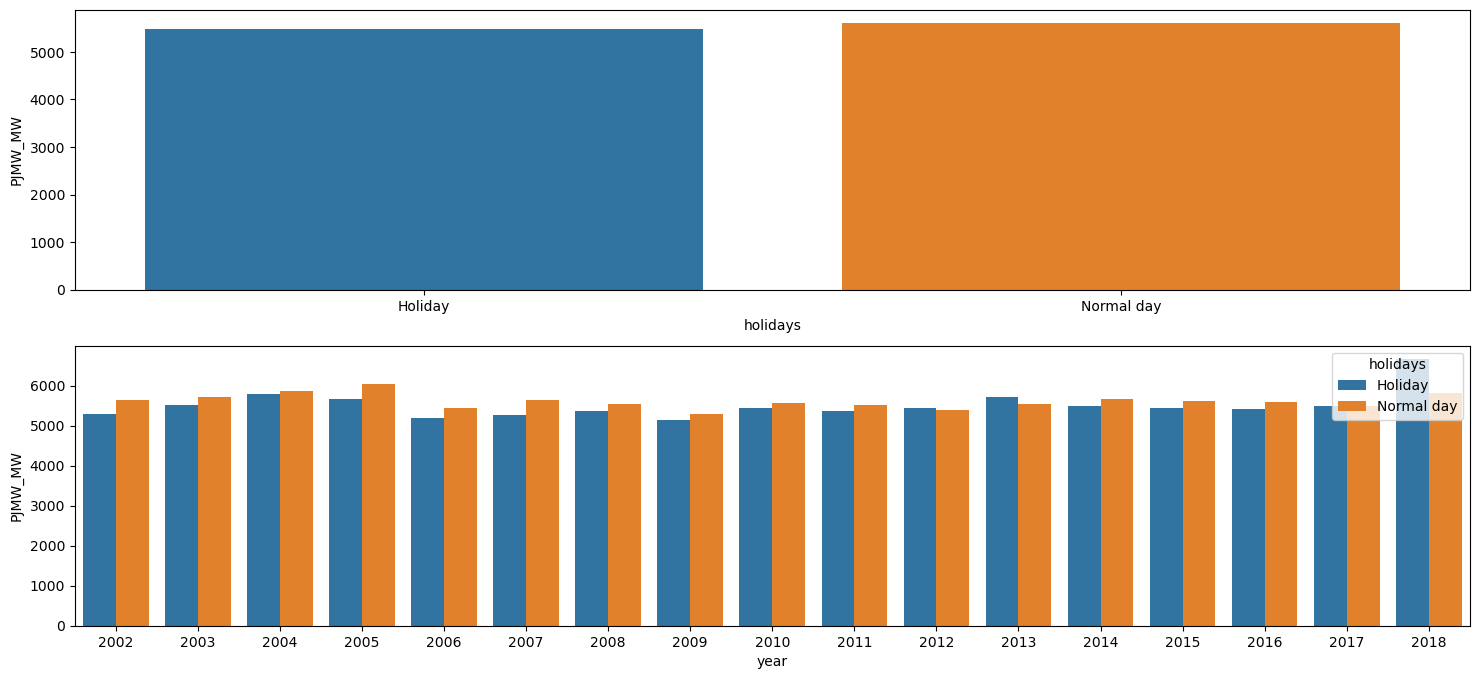

In [91]:
plt.figure(figsize=(18,8))

aux1 = df[['holidays', 'PJMW_MW']].groupby( 'holidays' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='holidays', y='PJMW_MW', data=aux1 )

aux2 = df[['year', 'holidays', 'PJMW_MW']].groupby( ['year', 'holidays'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='year', y='PJMW_MW', hue='holidays', data=aux2 )

## Decomposition
We will de-compose the time series into trend, seasonal and residuals

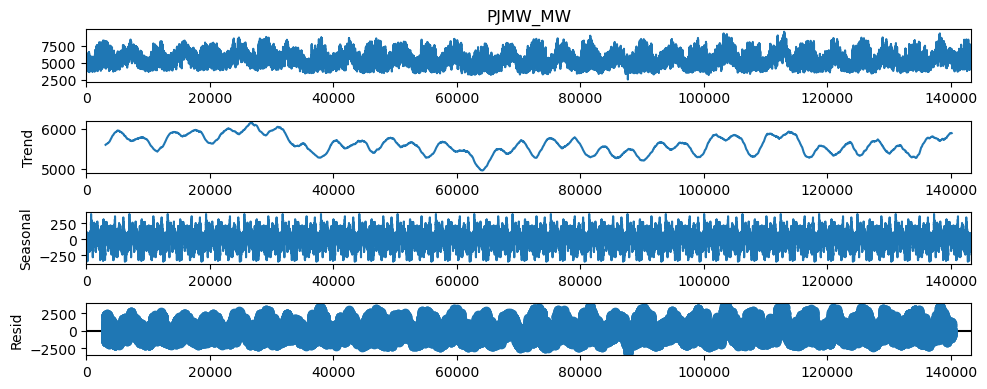

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df.PJMW_MW,period=6205)
decompose.plot()
plt.show()

This graph gives us an overall trend in our data from year 2002 till year 2018.
Seasonality cannot be checked as the datapoints are too many.


#### Lets resample and aggregate up to weekly level to reduce the noise

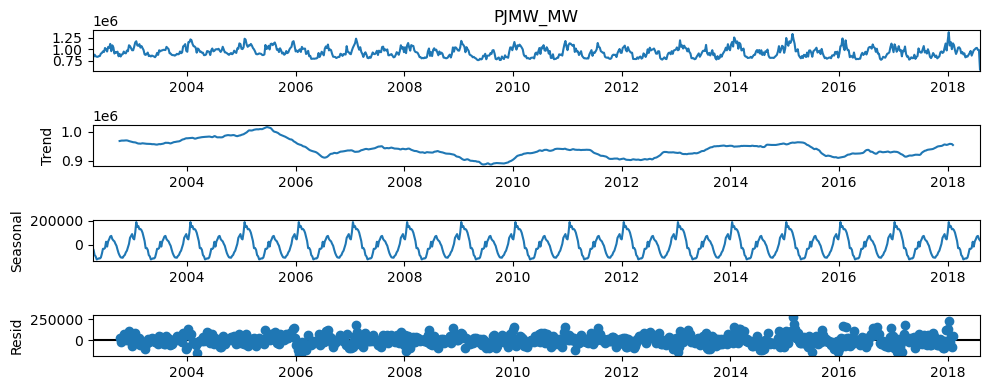

In [79]:
plt.rcParams["figure.figsize"]= (10,4)
weekly_data = data.PJMW_MW.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') # Aggregate to weekly level
fig = decomposition.plot()
plt.show()

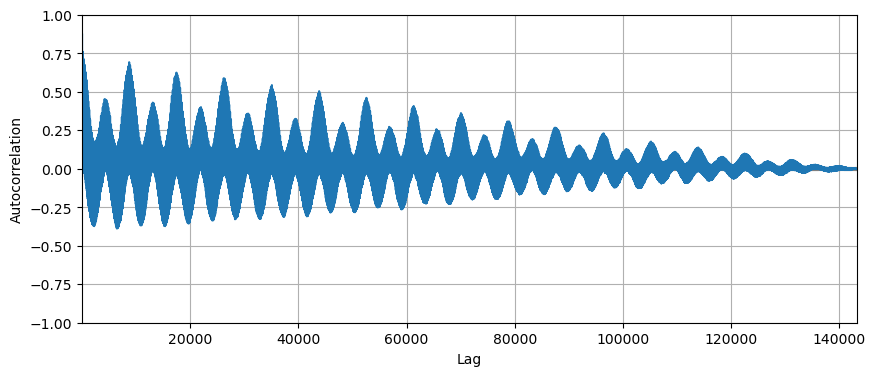

In [80]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df.PJMW_MW)
plt.show()

### Ljung Box test

In [81]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data, lags=[1], return_df=True)

lb_stat  lb_pvalue
1  136113.053316        0.0

Since lb_pvalue < 0.05, residuals are uncorrelated. If the residuals are correlated, we can perform transformations to see if it stabilizes the variance. It's also an indication that we may need to use exogenous variable to fully explain the time series behaviour or use higher order models.
In this case, the residuals are uncorrelated.

#### LAG PLOT

A lag plot is used to help evaluate whether the values in a dataset or time series are random. If the data are random, the lag plot will exhibit no identifiable pattern. If the data are not random, the lag plot will demonstrate a clearly identifiable pattern

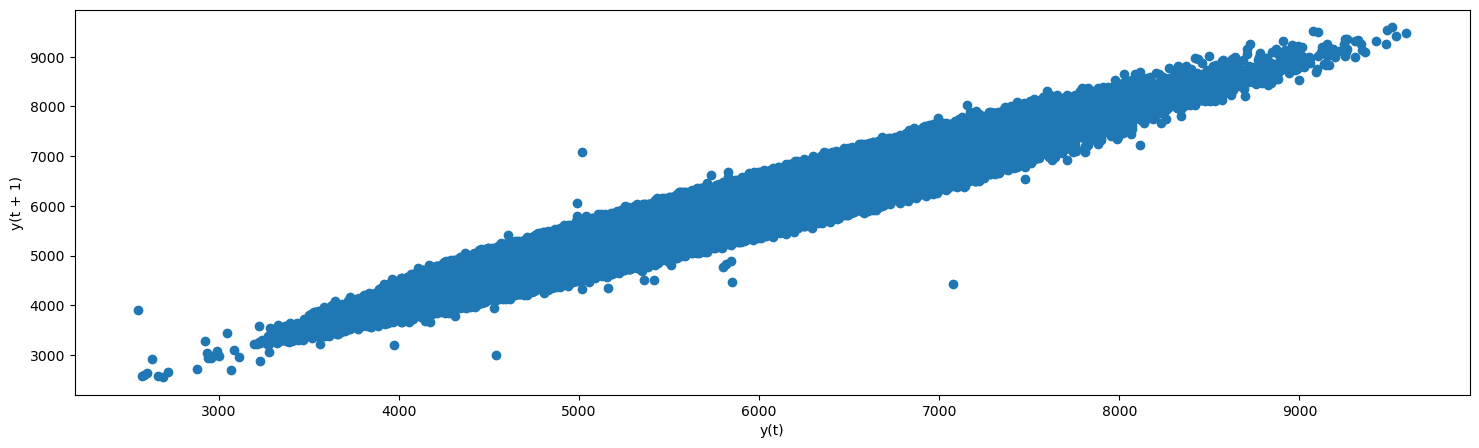

In [82]:
from pandas.plotting import lag_plot
plt.figure(figsize=(18,5))
lag_plot(df.PJMW_MW)
plt.show()

Our data has Moderate Autocorrelation as the lag plot is in eliptical shape.

# Check for Stationarity

### 1.Constant mean

Mean is: 5602.245472380474


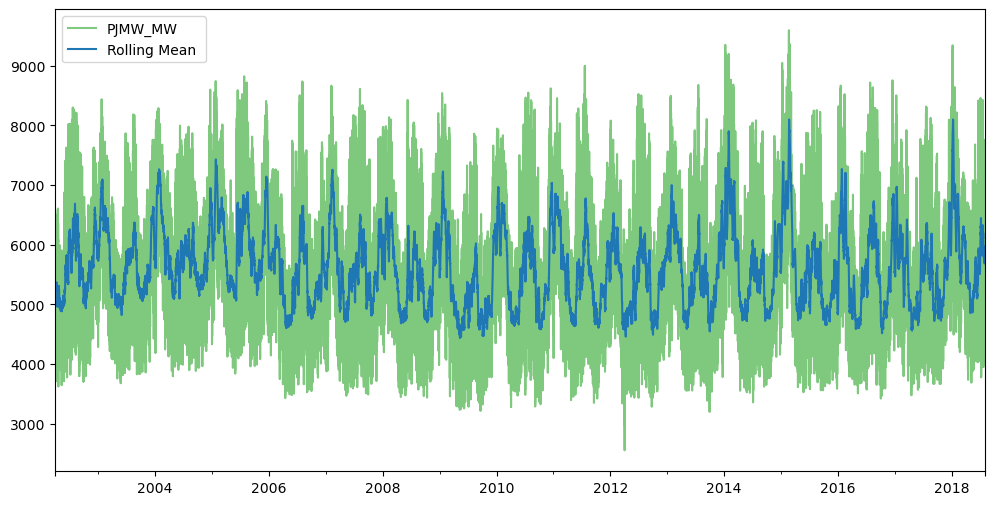

In [98]:
data.plot(figsize=(12,6), legend=True, label="Data", cmap='Accent')
data["PJMW_MW"].rolling(200, center=False).mean().plot(legend=True, label="Rolling Mean ");
print("Mean is:", data["PJMW_MW"].mean())

### 2) constant variance

S.D is: 979.0860631744555


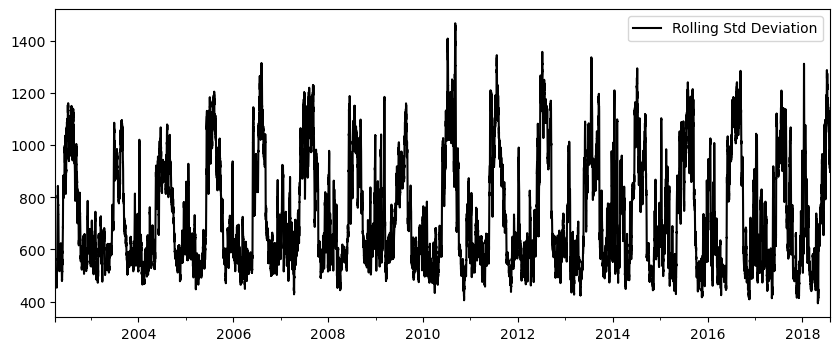

In [103]:
data["PJMW_MW"].rolling(200).std().plot(legend=True, label="Rolling Std Deviation",cmap='CMRmap');
print("S.D is:", data["PJMW_MW"].std())

Both mean and variance are constant.

### Coefficient of Variation:

Coefficient of variation gives us an idea about the variability in the process.

c.v = s.d/mean

If C.V<0.75 => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3 => High Variability

In [166]:
cv = df["PJMW_MW"].std()/df["PJMW_MW"].mean()
cv

0.1747667195237034

CV < 0.75 Hence its a low variability process

#### Augmented Dickey-fuller test

The output received from the ADF test indicates that the time series data is stationary. This is because the ADF statistic value of -19.947104 is more negative than the critical value at the 1% level of significance (-3.430), and the p-value is less than 0.05, which means we can reject the null hypothesis of non-stationarity.

In summary, the ADF test suggests that the time series data is stationary and it does not require any differencing to be performed before modeling.

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df.PJMW_MW , autolag= 'AIC')
print("1. ADF :" , dftest[0])
print("2. P-Value :" , dftest[1])
print("3. Num of lags :" , dftest[2])
print("4. No of obs used for ADF regression and critical value calculation :" , dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t",key, ": " , val)

Our p-value is definitely less than 0.05 and so we can say with pretty good confidence that we can reject the null (unit root, non-stationary data) and can assume our data is stationary.

### ACF & PACF Plot

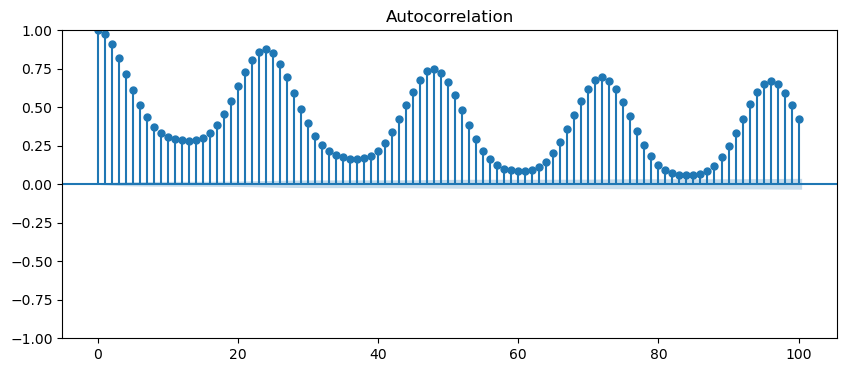

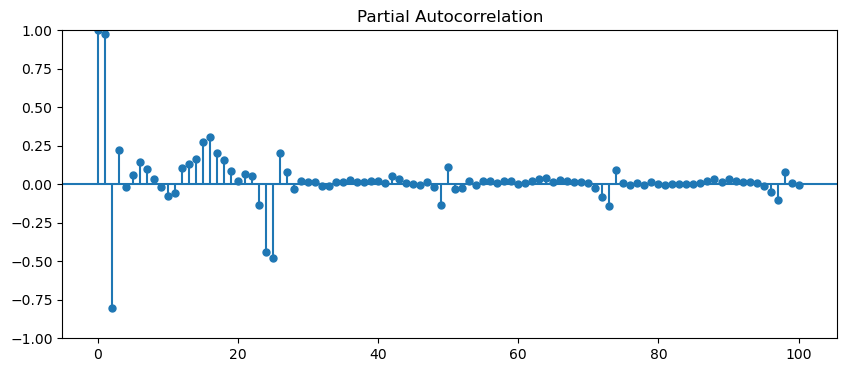

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot autocorrelation and partial autocorrelation plots
plot_acf(data['PJMW_MW'], lags=100)
plot_pacf(data['PJMW_MW'], lags=100)

# Show the plots
plt.show()

#### Downsample data to daily basis

In [107]:
daily_data = data.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [112]:
daily_data

PJMW_MW
2002-04-01  5271.173913
2002-04-02  5310.416667
2002-04-03  5325.916667
2002-04-04  5670.791667
2002-04-05  5686.125000
...                 ...
2018-07-30  5492.708333
2018-07-31  5660.750000
2018-08-01  5959.708333
2018-08-02  5805.041667
2018-08-03  5489.000000

[5969 rows x 1 columns]

### Differencing the daily data to remove seasonality

In [113]:
fig, axes = plt.subplots(2,1,figsize=(10,5),dpi=100,sharex=True)
data=daily_data.PJMW_MW
axes[0].plot(data[:], label = "Original series")
axes[0].plot(data[:].diff(1), label = "single differencing")
axes[0].set_title("single differencing")
plt.legend(loc='upper left', fontsize=10)

#Second differencing with 7 lags

axes[1].plot(data[:], label = "Original series")
axes[1].plot(data[:].diff(7), label = "Seasonal differencing",color='green')
axes[1].set_title("Seasonal differencing")
plt.legend(loc='upper left', fontsize=10)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [114]:
import statsmodels.graphics.tsaplots as tsa_plots

#### single differencing

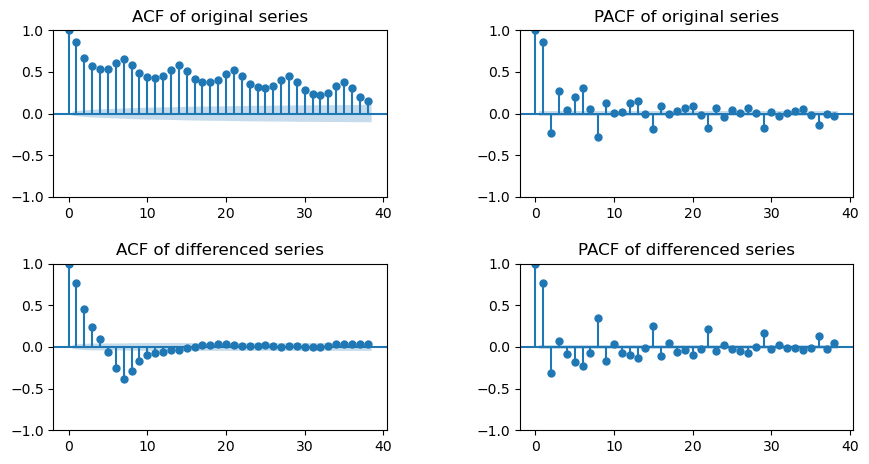

In [115]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Double Differencing

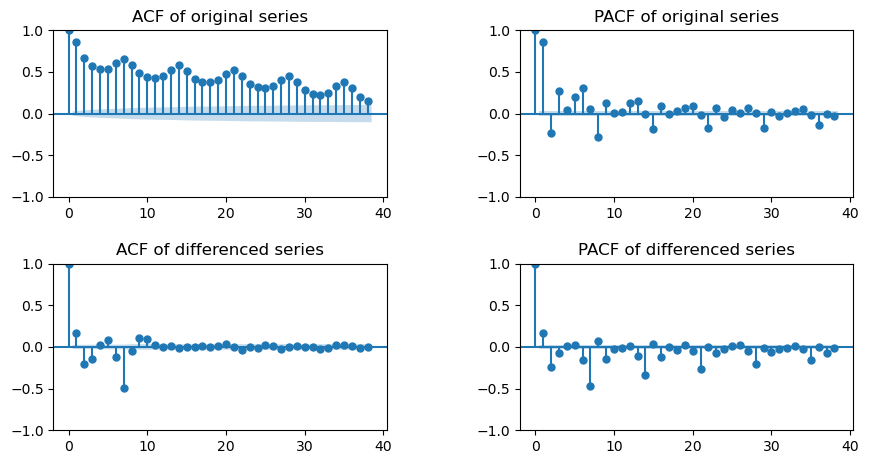

In [116]:
fig,axes = plt.subplots(2,2,figsize=(10,5))
tsa_plots.plot_acf(daily_data, ax=axes[0,0]); axes[0,0].set_title('ACF of original series')
tsa_plots.plot_pacf(daily_data, ax=axes[0,1]); axes[0,1].set_title('PACF of original series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of differenced series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of differenced series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

# SARIMA MODEL

### train test split 

In [117]:
train = daily_data.loc[:'2017-08-04']
test = daily_data['2017-08-04':]

In [118]:
train.shape,test.shape


((5605, 1), (365, 1))

In [119]:
# Plot train and test so you can see where we have split
test.rename(columns={'PJMW_MW': 'TEST SET'}).join(train.rename(columns={'PJMW_MW': 'TRAINING SET'}),
          how='outer').plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

#### diff 7

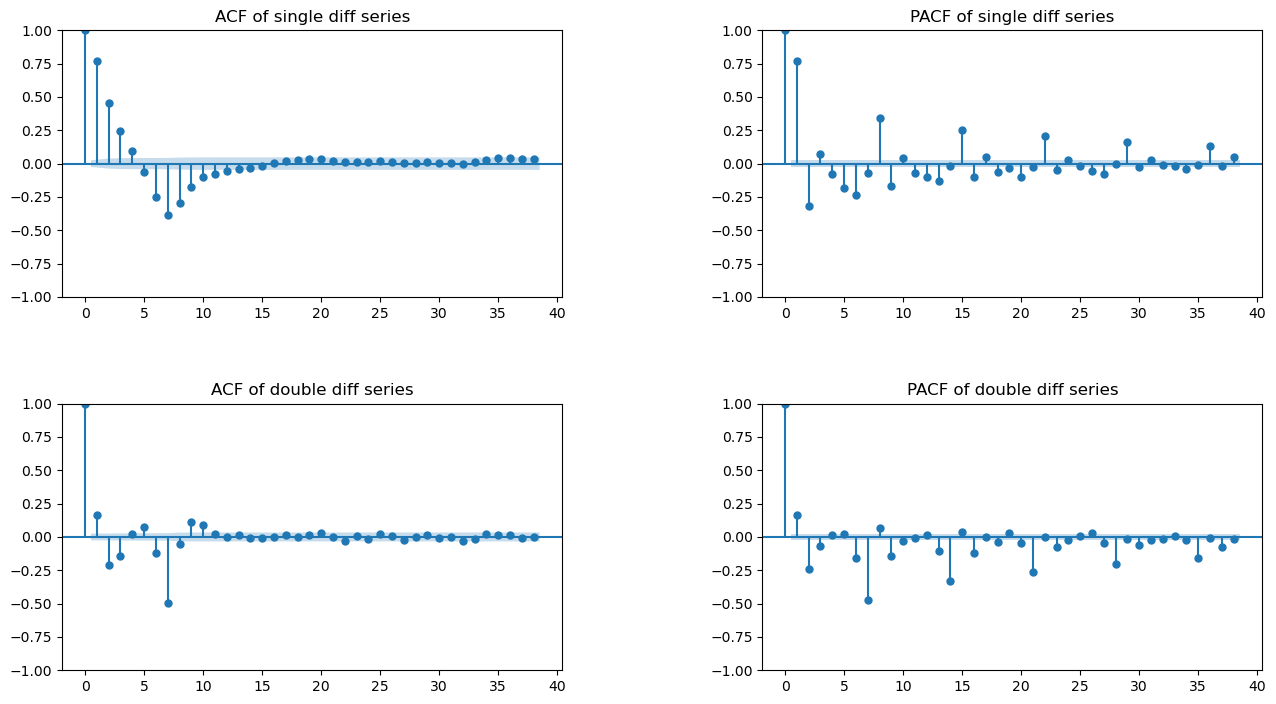

In [120]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(7).dropna(), ax=axes[0,0]); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(7).dropna(), ax=axes[0,1]); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=1 q=3 P=1 Q=0

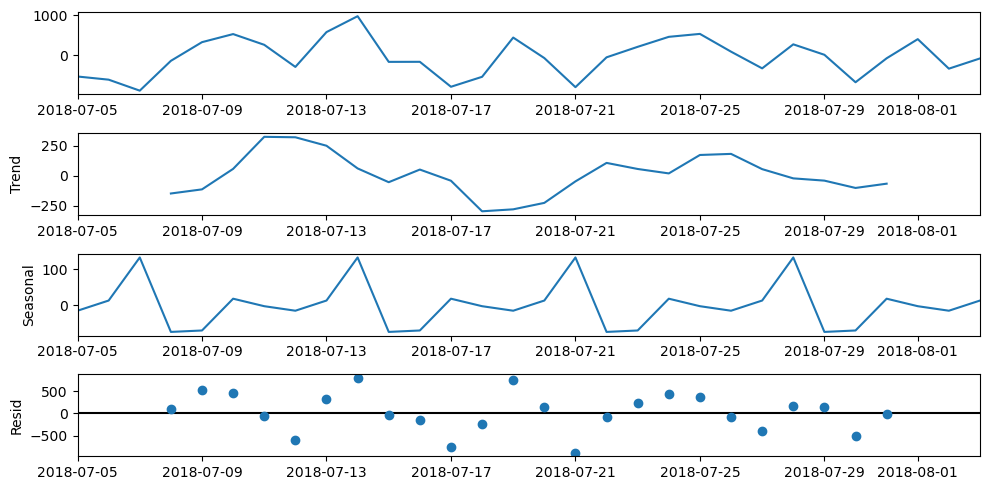

In [121]:
diff7=daily_data.diff(7).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff7[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()


In [122]:
model_7=sm.tsa.statespace.SARIMAX(train,order=(1,1,3),seasonal_order=(1,1,0,7))
fitted_7 = model_7.fit(disp=-1)
print(fitted_7.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(1, 1, 3)x(1, 1, [], 7)   Log Likelihood              -40300.003
Date:                            Mon, 17 Apr 2023   AIC                          80612.005
Time:                                    12:16:44   BIC                          80651.785
Sample:                                04-01-2002   HQIC                         80625.868
                                     - 08-04-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6305      0.017     37.554      0.000       0.598       0.663
ma.L1         -0.5792      1.801   

In [136]:
n_steps = 365
fc7 = fitted_7.forecast(n_steps,alpha=0.05)

## Model Evaluation

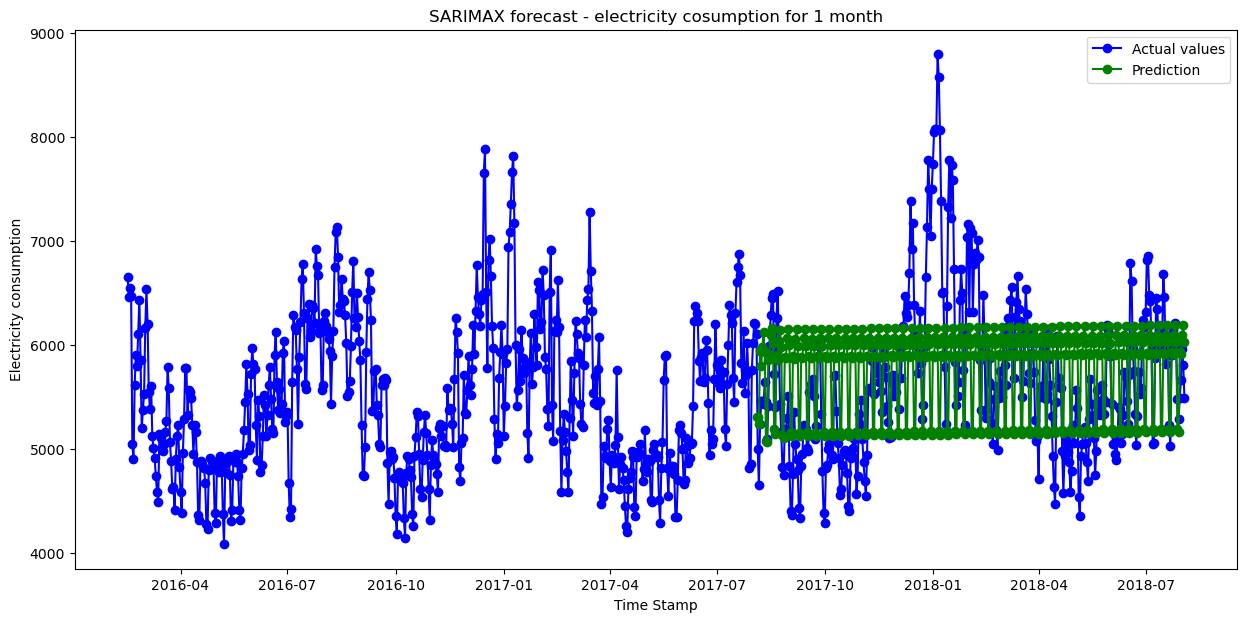

In [137]:

fitted_series7 = pd.Series(fc7,index=test.index)
fitted_series7=fitted_series7.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series7[-365:].index, fitted_series7[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [138]:
def mape(forecast,actual):
    mape=round(np.mean(np.abs(forecast - actual)/np.abs(actual))*100,2)
    return mape

In [139]:
def mae(forecast,actual):
    mae=round(np.mean(np.abs(forecast - actual)),2)
    return mae

In [140]:
def rmse(forecast,actual):
    rmse = round(np.mean(np.abs(forecast - actual)**2)**.5,2)
    return rmse

In [141]:
MAPE_7= mape(fitted_series7.values, test.values)
MAE_7= mae(fitted_series7.values, test.values)
print("MAPE_7: ",MAPE_7)
print("MAE_7: ",MAE_7)

MAPE_7:  12.06
MAE_7:  684.23


In [142]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_7=sqrt((mean_squared_error(fitted_series7.values,test.values)))
rmse_7

767.3478428159034

### Diff 30

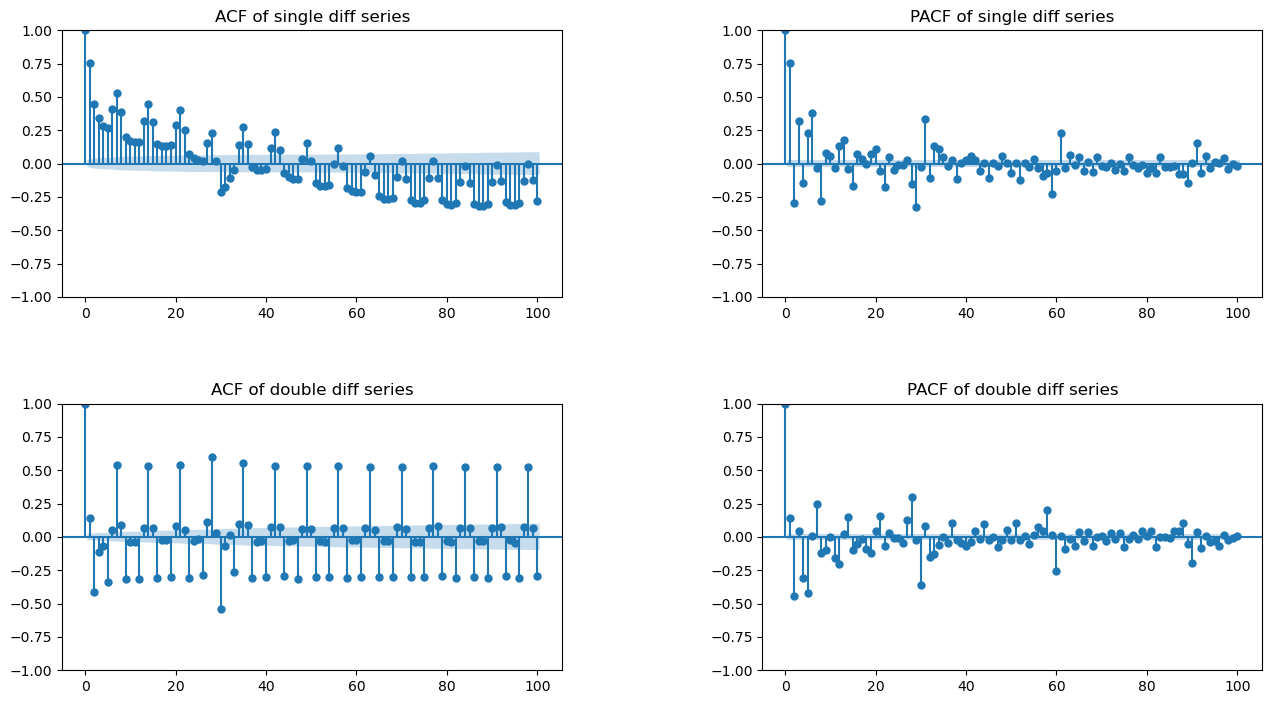

In [147]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(30).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(30).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(30).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(30).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

## Diff 70

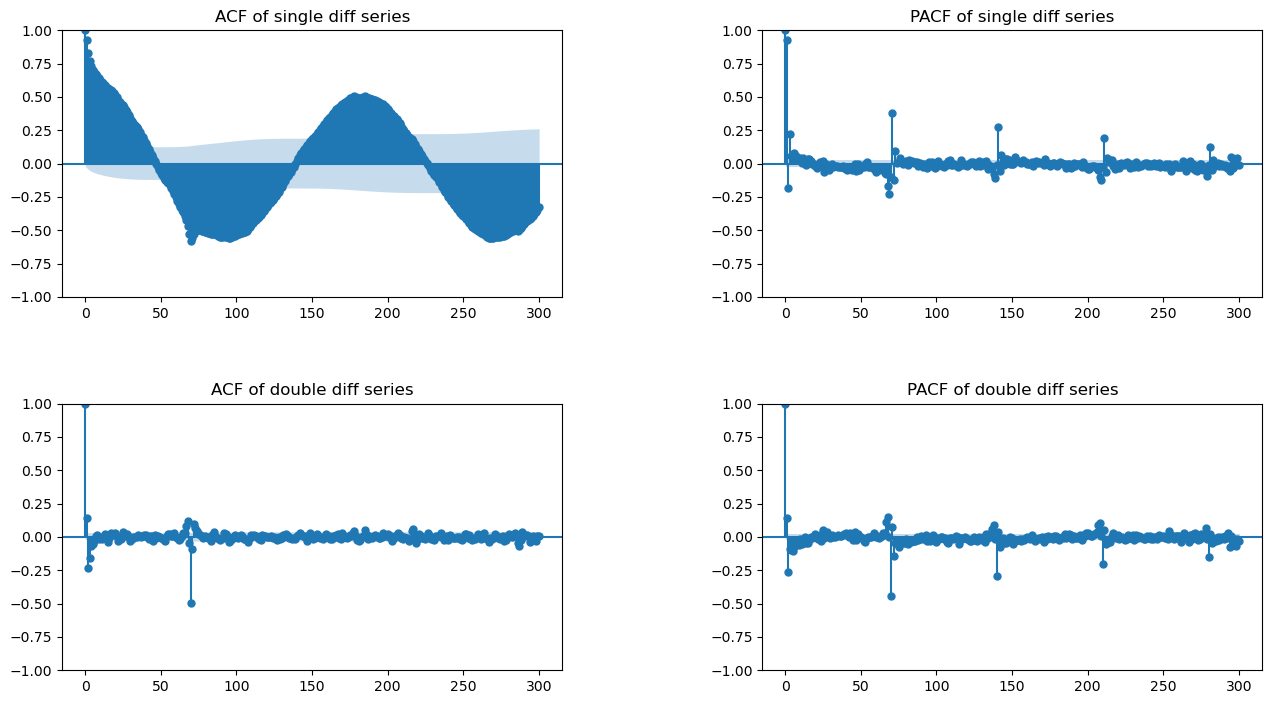

In [148]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(70).dropna(), ax=axes[0,0],lags=300); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(70).dropna(), ax=axes[0,1],lags=300); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(70).diff().dropna(), ax=axes[1,0],lags=300); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(70).diff().dropna(), ax=axes[1,1],lags=300); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

In [149]:
data_10year=daily_data['2008-01-01':'2017-08-03']

In [150]:
data_10year

PJMW_MW
2008-01-01  5657.125000
2008-01-02  6920.250000
2008-01-03  7223.416667
2008-01-04  6963.250000
2008-01-05  6016.958333
...                 ...
2017-07-30  4859.875000
2017-07-31  5757.750000
2017-08-01  6015.666667
2017-08-02  6215.958333
2017-08-03  6205.958333

[3503 rows x 1 columns]

In [134]:
model_70=sm.tsa.statespace.SARIMAX(data_10year,order=(2,1,3),seasonal_order=(1,1,0,70))
fitted_70 = model_70.fit(low_memory=True, disp=-1)
print(fitted_70.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 3503
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 70)   Log Likelihood              -25010.943
Date:                             Mon, 17 Apr 2023   AIC                          50035.886
Time:                                     12:33:20   BIC                          50078.872
Sample:                                 01-01-2008   HQIC                         50051.243
                                      - 08-03-2017                                         
Covariance Type:                            approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5046      0.029     51.791      0.000       1.448       1.562
ar.L2         -0.5146      

In [135]:
n_steps = 365
fc70 = fitted_70.forecast(n_steps,alpha=0.05)

## Evaluvate Model

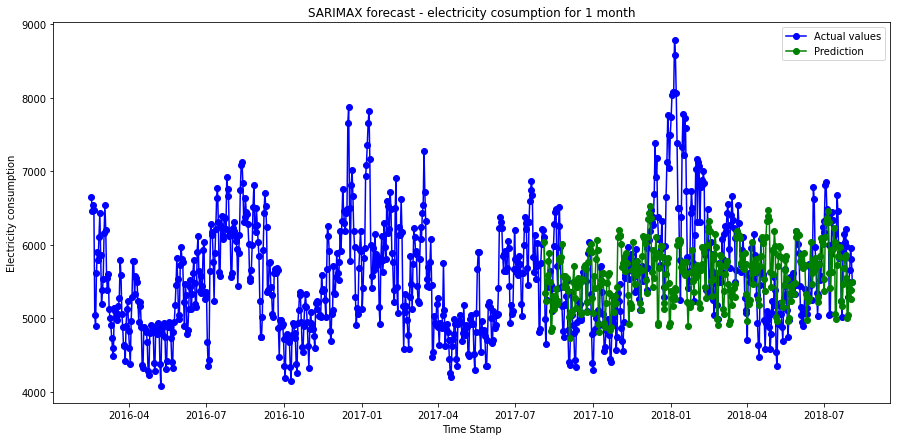

In [322]:

fitted_series70 = pd.Series(fc70,index=test.index)
fitted_series70=fitted_series70.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series70[-365:].index, fitted_series70[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [323]:
MAPE_70= mape(fitted_series70.values, test.values)
MAE_70= mae(fitted_series70.values, test.values)
print("MAPE_70: ",MAPE_70)
print("MAE_70: ",MAE_70)

MAPE_70:  11.32
MAE_70:  658.15


In [324]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_70=sqrt((mean_squared_error(fitted_series70.values,test.values)))
rmse_70

788.662673335869

### Diff 90

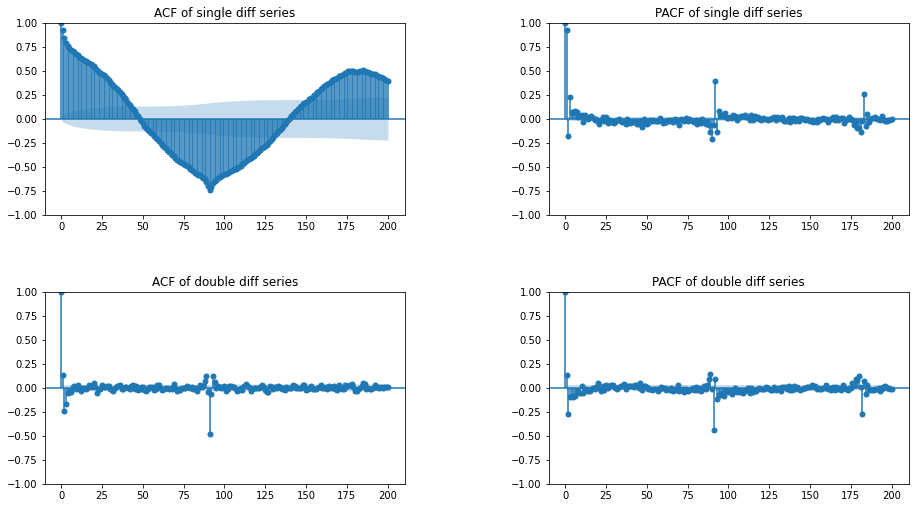

In [78]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(91).dropna(), ax=axes[0,0],lags=200); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(91).dropna(), ax=axes[0,1],lags=200); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(91).diff().dropna(), ax=axes[1,0],lags=200); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(91).diff().dropna(), ax=axes[1,1],lags=200); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,P=1,q=0

In [155]:
model_90=sm.tsa.statespace.SARIMAX(train,order=(2,1,3),seasonal_order=(1,1,0,90))
fitted_90 =model_90.fit(low_memory=True,cov_type='approx',maxiter=100)
print(fitted_90.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 90)   Log Likelihood              -41417.585
Date:                             Mon, 17 Apr 2023   AIC                          82849.169
Time:                                     15:10:46   BIC                          82895.474
Sample:                                 04-01-2002   HQIC                         82865.318
                                      - 08-04-2017                                         
Covariance Type:                            approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1234      0.034     -3.620      0.000      -0.190      -0.057
ar.L2         -0.1633      

In [156]:
n_steps = 365
fc90 = fitted_90.forecast(n_steps,alpha=0.05)

## Evaluate model

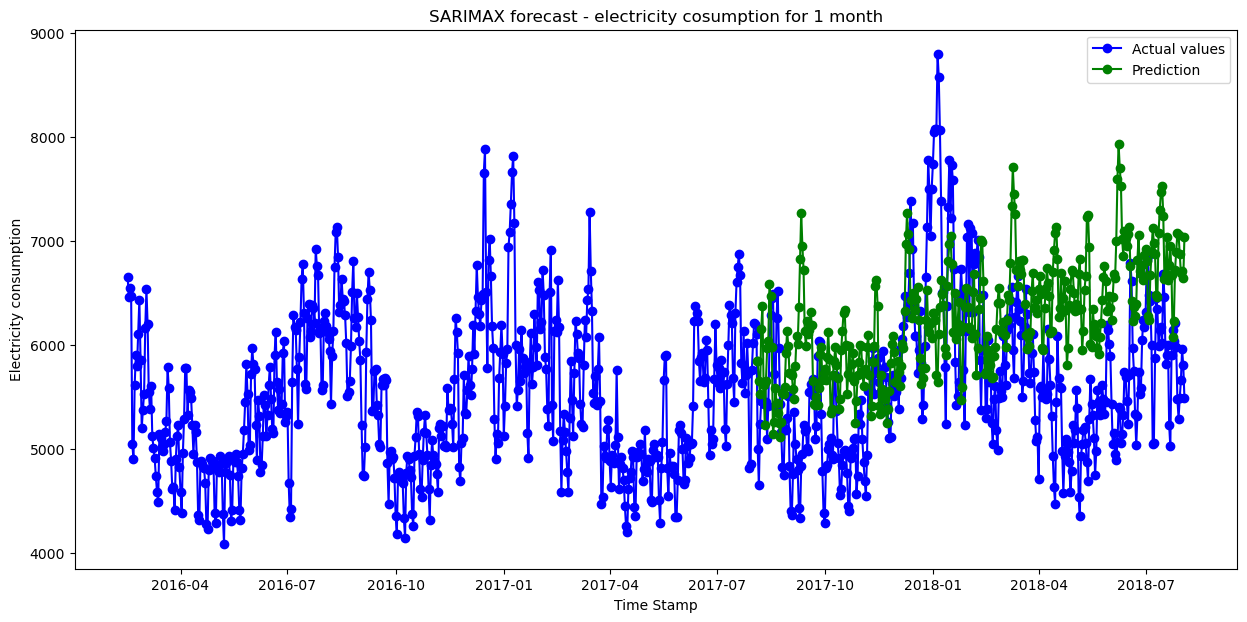

In [157]:
fitted_series90 = pd.Series(fc90,index=test.index)
fitted_series90=fitted_series90.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series90[-365:].index, fitted_series90[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [158]:
MAPE_90= mape(fitted_series90.values, test.values)
MAE_90= mae(fitted_series90.values, test.values)
print("MAPE_90: ",MAPE_90)
print("MAE_90: ",MAE_90)

MAPE_90:  16.42
MAE_90:  893.36


In [159]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_90=sqrt((mean_squared_error(fitted_series90.values,test.values)))
rmse_90

1035.722866239794

### Diff 120

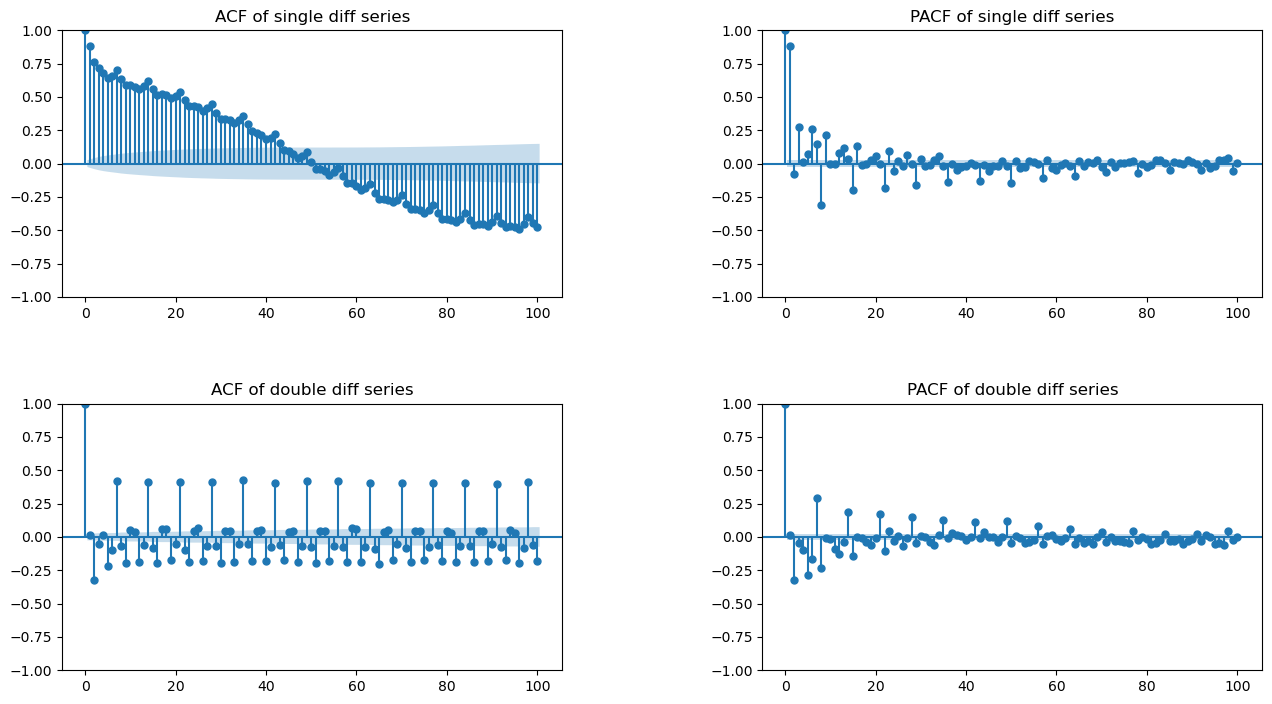

In [160]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(120).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(120).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(120).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(120).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Diff 140

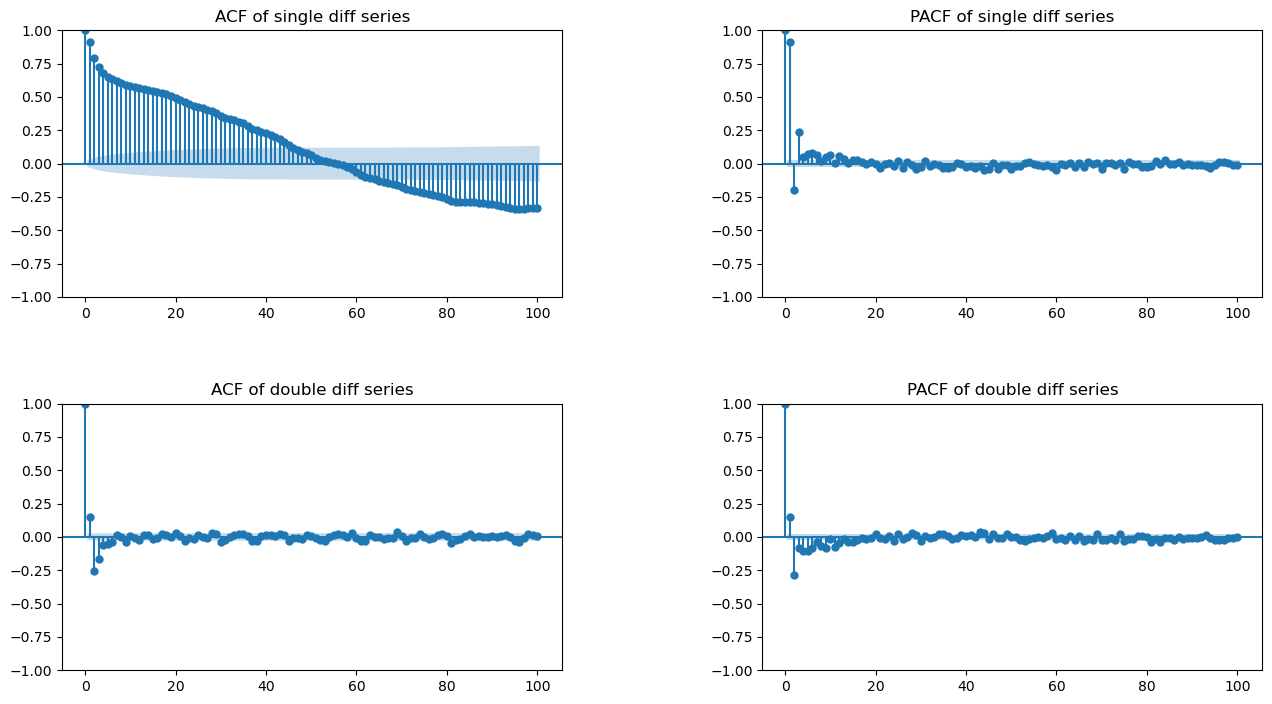

In [161]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(140).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(140).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(140).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(140).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,Q=0,P=0

In [162]:
diff140=daily_data.diff(140).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff140[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()

In [86]:
data_3year=daily_data['2015-08-03':'2017-08-03']

In [87]:
model_140=sm.tsa.statespace.SARIMAX(data_3year,order=(2,1,3),seasonal_order=(1,1,0,140))
fitted_140 = model_140.fit(disp=-1)
print(fitted_140.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              PJMW_MW   No. Observations:                  732
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 140)   Log Likelihood               -4334.322
Date:                              Tue, 11 Oct 2022   AIC                           8682.645
Time:                                      00:09:53   BIC                           8713.317
Sample:                                  08-03-2015   HQIC                          8694.593
                                       - 08-03-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6828      0.422      1.617      0.106      -0.145       1.510
ar.L2         -0.13

In [93]:
n_steps = 365
fc140 = fitted_140.forecast(n_steps,alpha=0.05)

## Evaluate the model

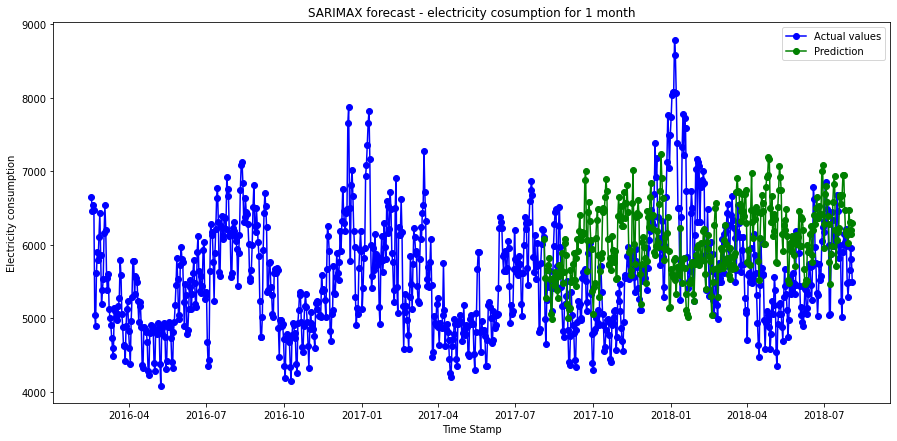

In [94]:
fitted_series140 = pd.Series(fc140,index=test.index)
fitted_series140=fitted_series140.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series140[-365:].index, fitted_series140[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [95]:
MAPE_140= mape(fitted_series140.values, test.values)
MAE_140= mae(fitted_series140.values, test.values)
print("MAPE_140: ",MAPE_140)
print("MAE_140: ",MAE_140)

MAPE_140:  14.17
MAE_140:  780.78


In [96]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_140=sqrt((mean_squared_error(fitted_series140.values,test.values)))
rmse_140

974.0461745188588

# Diff 365

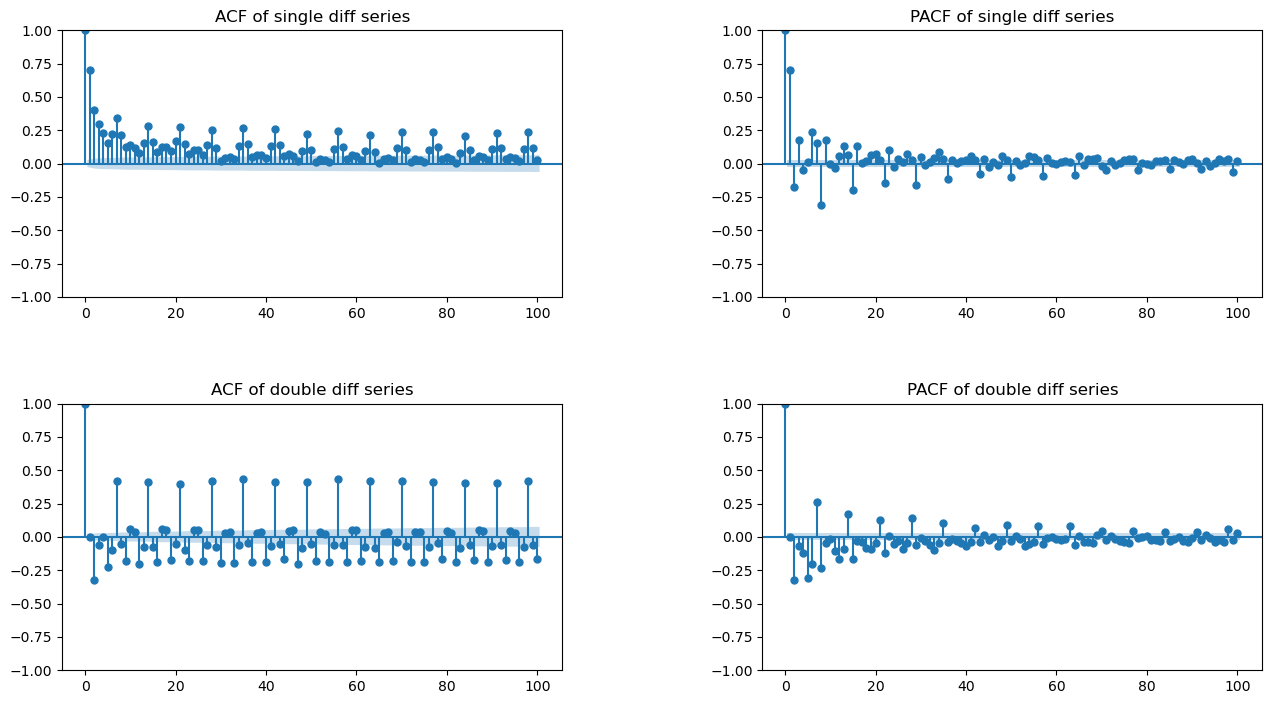

In [163]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(365).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(365).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(365).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(365).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

### Diff 364

In [164]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data.diff(364).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data.diff(364).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data.diff(364).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data.diff(364).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,P=1,Q=0

In [72]:
data_2year=daily_data['2015-08-03':'2017-08-03']

In [73]:
model_364=sm.tsa.statespace.SARIMAX(data_2year,order=(3,1,3),seasonal_order=(1,1,0,364))
fitted_364 = model_364.fit(low_memory=True,cov_type='approx')
print(fitted_364.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              PJMW_MW   No. Observations:                  732
Model:             SARIMAX(3, 1, 3)x(1, 1, [], 364)   Log Likelihood               -2697.475
Date:                              Thu, 13 Oct 2022   AIC                           5410.950
Time:                                      12:19:47   BIC                           5442.193
Sample:                                  08-03-2015   HQIC                          5423.364
                                       - 08-03-2017                                         
Covariance Type:                             approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0089      0.058     34.574      0.000       1.895       2.123
ar.L2         -1.32

In [74]:
n_steps = 365
fc364 = fitted_364.forecast(n_steps,alpha=0.05)

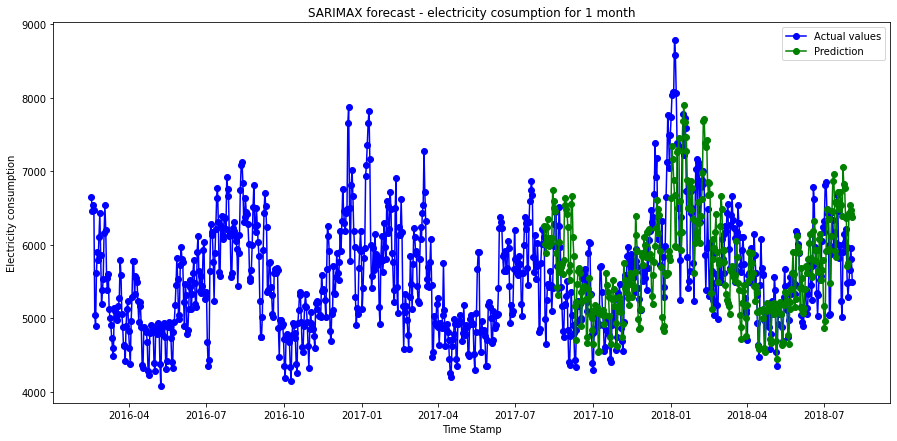

In [75]:
fitted_series364 = pd.Series(fc364,index=test.index)
fitted_series364=fitted_series364.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data[-900:].index,daily_data[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series364[-365:].index, fitted_series364[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [80]:
MAPE_364= mape(fitted_series364.values, test.values)
MAE_364= mae(fitted_series364.values, test.values)
print("MAPE_364: ",MAPE_364)
print("MAE_364: ",MAE_364)

MAPE_364:  14.07
MAE_364:  802.73


In [81]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_364=sqrt((mean_squared_error(fitted_series364.values,test.values)))
rmse_364

678.8247080893625

# REGRESSION MODEL

<AxesSubplot:>

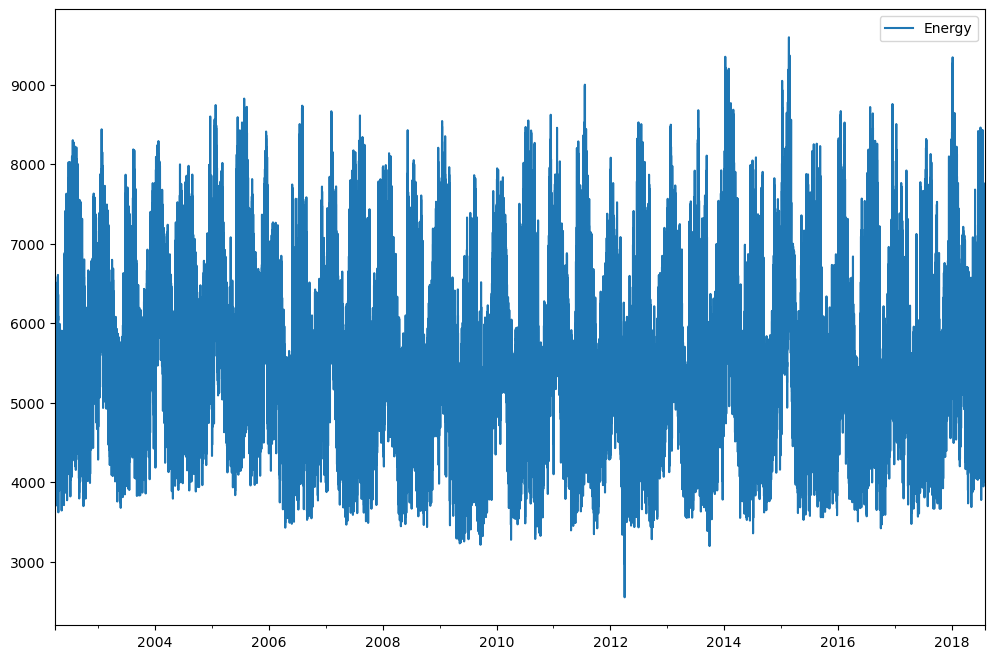

In [83]:
data.columns = ['Energy']
data.plot(figsize=(12,8))

In [84]:
daily_data = data.resample(rule='D').mean()
daily_data = daily_data.asfreq('D')

In [85]:
daily_data

Energy
2002-04-01  5271.173913
2002-04-02  5310.416667
2002-04-03  5325.916667
2002-04-04  5670.791667
2002-04-05  5686.125000
...                 ...
2018-07-30  5492.708333
2018-07-31  5660.750000
2018-08-01  5959.708333
2018-08-02  5805.041667
2018-08-03  5489.000000

[5969 rows x 1 columns]

In [86]:
daily_data1=daily_data.copy()

In [87]:
daily_data

Energy
2002-04-01  5271.173913
2002-04-02  5310.416667
2002-04-03  5325.916667
2002-04-04  5670.791667
2002-04-05  5686.125000
...                 ...
2018-07-30  5492.708333
2018-07-31  5660.750000
2018-08-01  5959.708333
2018-08-02  5805.041667
2018-08-03  5489.000000

[5969 rows x 1 columns]

In [88]:
daily_data['energy_1dayback']=daily_data['Energy'].shift(+1)
daily_data['energy_2dayback']=daily_data['Energy'].shift(+2)
daily_data['energy_3dayback']=daily_data['Energy'].shift(+3)
daily_data['energy_4dayback']=daily_data['Energy'].shift(+4)
daily_data['energy_5dayback']=daily_data['Energy'].shift(+5)
daily_data['energy_6dayback']=daily_data['Energy'].shift(+6)
daily_data['energy_7dayback']=daily_data['Energy'].shift(+7)

daily_data.head(10)

Energy  energy_1dayback  energy_2dayback  energy_3dayback  \
2002-04-01  5271.173913              NaN              NaN              NaN   
2002-04-02  5310.416667      5271.173913              NaN              NaN   
2002-04-03  5325.916667      5310.416667      5271.173913              NaN   
2002-04-04  5670.791667      5325.916667      5310.416667      5271.173913   
2002-04-05  5686.125000      5670.791667      5325.916667      5310.416667   
2002-04-06  5367.791667      5686.125000      5670.791667      5325.916667   
2002-04-07  5052.479167      5367.791667      5686.125000      5670.791667   
2002-04-08  5283.875000      5052.479167      5367.791667      5686.125000   
2002-04-09  5136.083333      5283.875000      5052.479167      5367.791667   
2002-04-10  5171.666667      5136.083333      5283.875000      5052.479167   

            energy_4dayback  energy_5dayback  energy_6dayback  energy_7dayback  
2002-04-01              NaN              NaN              NaN              NaN  
2002-04-02              NaN              NaN              NaN              NaN  
2002-04-03              NaN              NaN              NaN              NaN  
2002-04-04              NaN              NaN              NaN              NaN  
2002-04-05      5271.173913              NaN              NaN              NaN  
2002-04-06      5310.416667      5271.173913              NaN              NaN  
2002-04-07      5325.916667      5310.416667      5271.173913              NaN  
2002-04-08      5670.791667      5325.916667      5310.416667      5271.173913  
2002-04-09      5686.125000      5670.791667      5325.916667      5310.416667  
2002-04-10      5367.791667      5686.125000      5670.791667      5325.916667

In [89]:
daily_data=daily_data.dropna()
daily_data

Energy  energy_1dayback  energy_2dayback  energy_3dayback  \
2002-04-08  5283.875000      5052.479167      5367.791667      5686.125000   
2002-04-09  5136.083333      5283.875000      5052.479167      5367.791667   
2002-04-10  5171.666667      5136.083333      5283.875000      5052.479167   
2002-04-11  5207.875000      5171.666667      5136.083333      5283.875000   
2002-04-12  5090.416667      5207.875000      5171.666667      5136.083333   
...                 ...              ...              ...              ...   
2018-07-30  5492.708333      5293.833333      5485.791667      5978.750000   
2018-07-31  5660.750000      5492.708333      5293.833333      5485.791667   
2018-08-01  5959.708333      5660.750000      5492.708333      5293.833333   
2018-08-02  5805.041667      5959.708333      5660.750000      5492.708333   
2018-08-03  5489.000000      5805.041667      5959.708333      5660.750000   

            energy_4dayback  energy_5dayback  energy_6dayback  energy_7dayback  
2002-04-08      5670.791667      5325.916667      5310.416667      5271.173913  
2002-04-09      5686.125000      5670.791667      5325.916667      5310.416667  
2002-04-10      5367.791667      5686.125000      5670.791667      5325.916667  
2002-04-11      5052.479167      5367.791667      5686.125000      5670.791667  
2002-04-12      5283.875000      5052.479167      5367.791667      5686.125000  
...                     ...              ...              ...              ...  
2018-07-30      6216.458333      6036.208333      6142.666667      5900.041667  
2018-07-31      5978.750000      6216.458333      6036.208333      6142.666667  
2018-08-01      5485.791667      5978.750000      6216.458333      6036.208333  
2018-08-02      5293.833333      5485.791667      5978.750000      6216.458333  
2018-08-03      5492.708333      5293.833333      5485.791667      5978.750000  

[5962 rows x 8 columns]

In [90]:
daily_data1.to_csv('dataset_daily.csv')

In [91]:
import numpy as np
x1,x2,x3,x4,x5,x6,x7,y=daily_data['energy_1dayback'],daily_data['energy_2dayback'],daily_data['energy_3dayback'],daily_data['energy_4dayback'],daily_data['energy_5dayback'],daily_data['energy_6dayback'],daily_data['energy_7dayback'],daily_data['Energy']
x1,x2,x3,x4,x5,x6,x7,y=np.array(x1),np.array(x2),np.array(x3),np.array(x4),np.array(x5),np.array(x6),np.array(x7),np.array(y)
x1,x2,x3,x4,x5,x6,x7,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),x4.reshape(-1,1),x5.reshape(-1,1),x6.reshape(-1,1),x7.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3,x4,x5,x6,x7),axis=1)
print(final_x)

[[5052.47916667 5367.79166667 5686.125      ... 5325.91666667
  5310.41666667 5271.17391304]
 [5283.875      5052.47916667 5367.79166667 ... 5670.79166667
  5325.91666667 5310.41666667]
 [5136.08333333 5283.875      5052.47916667 ... 5686.125
  5670.79166667 5325.91666667]
 ...
 [5660.75       5492.70833333 5293.83333333 ... 5978.75
  6216.45833333 6036.20833333]
 [5959.70833333 5660.75       5492.70833333 ... 5485.79166667
  5978.75       6216.45833333]
 [5805.04166667 5959.70833333 5660.75       ... 5293.83333333
  5485.79166667 5978.75      ]]


In [92]:
final_x

array([[5052.47916667, 5367.79166667, 5686.125     , ..., 5325.91666667,
        5310.41666667, 5271.17391304],
       [5283.875     , 5052.47916667, 5367.79166667, ..., 5670.79166667,
        5325.91666667, 5310.41666667],
       [5136.08333333, 5283.875     , 5052.47916667, ..., 5686.125     ,
        5670.79166667, 5325.91666667],
       ...,
       [5660.75      , 5492.70833333, 5293.83333333, ..., 5978.75      ,
        6216.45833333, 6036.20833333],
       [5959.70833333, 5660.75      , 5492.70833333, ..., 5485.79166667,
        5978.75      , 6216.45833333],
       [5805.04166667, 5959.70833333, 5660.75      , ..., 5293.83333333,
        5485.79166667, 5978.75      ]])

In [93]:
y

array([[5283.875     ],
       [5136.08333333],
       [5171.66666667],
       ...,
       [5959.70833333],
       [5805.04166667],
       [5489.        ]])

In [94]:
X_train,X_test,y_train,y_test=final_x[:-360],final_x[-360:],y[:-360],y[-360:]


# LR, RF and XGB Model

In [95]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()

In [96]:
from sklearn.ensemble import RandomForestRegressor
ran_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [97]:
ran_model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)


LinearRegression()

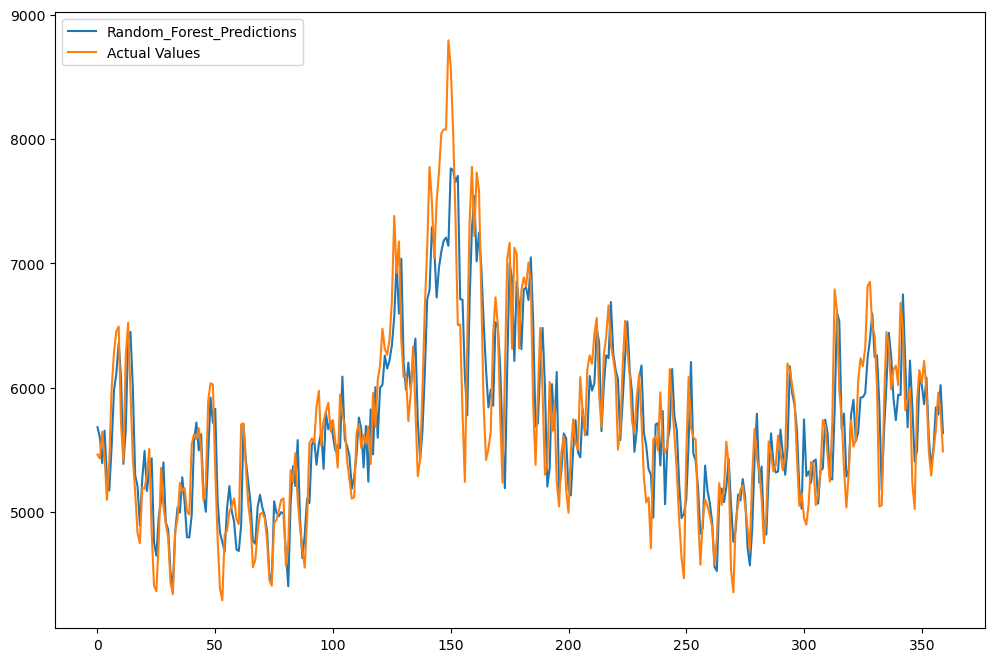

In [98]:
ran_pred=ran_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(ran_pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Values')
plt.legend(loc="upper left")
plt.show()

In [99]:
lin_pred=lin_model.predict(X_test)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

In [100]:
plt.scatter(y_test,lin_pred)

In [101]:
residual = y_test-lin_pred

In [102]:
sns.distplot(residual)

<AxesSubplot:ylabel='Density'>

In [103]:
plt.scatter(lin_pred,residual)

In [104]:
from xgboost import XGBRegressor

In [105]:
xg_model = XGBRegressor()

In [106]:
xg_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [107]:
predictions = xg_model.predict(X_test)

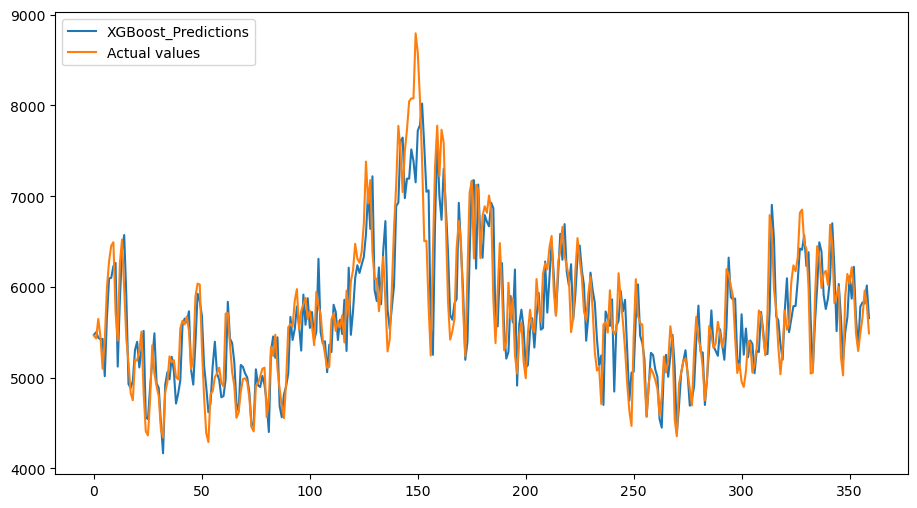

In [108]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,6)
plt.plot(predictions,label='XGBoost_Predictions')
plt.plot(y_test,label='Actual values')
plt.legend(loc="upper left")
plt.show()

# Calculate the RMSE,MAPE and MAE

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
from math import sqrt

RMSE_RF=sqrt(mean_squared_error(ran_pred,y_test))
RMSE_LR=sqrt(mean_squared_error(lin_pred,y_test))
MAE_RF = mean_absolute_error(ran_pred,y_test)
MAE_LR = mean_absolute_error(lin_pred,y_test)
MAPE_RF = round((mean_absolute_percentage_error(ran_pred,y_test)*100),3)
MAPE_LR = round((mean_absolute_percentage_error(lin_pred,y_test)*100),3)
MAE_XG = mean_absolute_error(y_test, predictions)
MAPE_XG= round((mean_absolute_percentage_error(y_test,predictions)*100),3)
RMSE_xg=sqrt(mean_squared_error(predictions,y_test))

In [110]:
print('RMSE for Random Forest Model is:',RMSE_RF)
print('MAE for Random Forest Model is:',MAE_RF)
print('MAPE for Random Forest Model is:',MAPE_RF)


RMSE for Random Forest Model is: 368.6254439808971
MAE for Random Forest Model is: 282.91269212962953
MAPE for Random Forest Model is: 4.878


In [111]:
print('RMSE for Linear Regression Model is:',RMSE_LR)
print('MAE for Linear Regression Model is:',MAE_LR)
print('MAPE for Linear Regression Model is:',MAPE_LR)

RMSE for Linear Regression Model is: 354.20301093846945
MAE for Linear Regression Model is: 274.2979319871215
MAPE for Linear Regression Model is: 4.766


In [112]:
print('RMSE for XG Boost Model is:',RMSE_xg)
print('MAE for XG Boos Model is:',MAE_XG)
print('MAPE for XG Boos Model is:',MAPE_XG)

RMSE for XG Boost Model is: 369.54075945630785
MAE for XG Boos Model is: 279.7743078161169
MAPE for XG Boos Model is: 4.787


## Calculate forecasting accuracy

### 1.LR Model

In [113]:
from sklearn.linear_model import LinearRegression
final_lin_model=LinearRegression()

final_lin_model.fit(final_x,y)

LinearRegression()

In [114]:
forecast_check_data = np.array(daily_data['Energy'][:'2018-07-04'][-7:])

In [115]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    lin_f_chk=final_lin_model.predict(ck)
    z=np.append(z,lin_f_chk)
    i=+1
future_pred_lr=z[-30:]

In [116]:
future_pred_lr

array([6087.30698243, 6215.23781337, 6141.78872178, 6140.95503201,
       6521.64884611, 6673.32885511, 6625.74301689, 6130.42261224,
       6230.89683313, 6129.21093749, 6053.91198391, 6328.97324473,
       6399.52865133, 6699.48816079, 6124.48191418, 6286.60218596,
       6113.94523744, 6007.62762667, 6269.99807754, 6067.27074396,
       6762.77167276, 6016.78716747, 6389.24537908, 6086.94168664,
       5946.96763053, 6367.37971162, 5662.41127027, 6912.44076143,
       5748.63500007, 6559.26714784])

In [117]:
future_chk = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df = pd.DataFrame(index=future_chk)

In [118]:
future_chk_df['future_chk_energy'] = future_pred_lr.tolist()

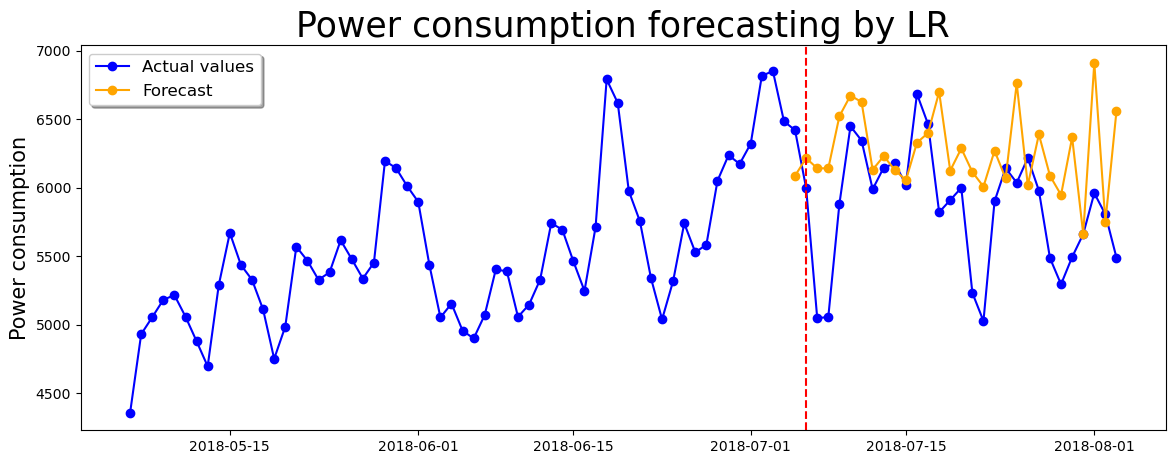

In [119]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by LR", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df.index,future_chk_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [120]:
daily_data_last_30 = daily_data['Energy'].tail(30)

In [121]:
MAE_check = mean_absolute_error(daily_data_last_30, future_chk_df)
MAPE_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df)*100),3)
RMSE_check=sqrt(mean_squared_error(future_chk_df,daily_data_last_30))


In [122]:
print('RMSE for forecast check is:',RMSE_check)
print('MAE for forecast check is:',MAE_check)
print('MAPE for forecast check is:',MAPE_check)

RMSE for forecast check is: 588.0840935079688
MAE for forecast check is: 461.5277038831659
MAPE for forecast check is: 8.25


### 2.RF Model

In [123]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [124]:
final_RF_model.fit(final_x,y)

RandomForestRegressor(max_features=3, random_state=1)

In [125]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    rf_f_chk=final_RF_model.predict(ck)
    z=np.append(z,rf_f_chk)
    i=+1
future_pred_RF=z[-30:]

In [126]:
future_pred_RF

array([5945.86958333, 6136.90791667, 6086.25333333, 6250.69875   ,
       6542.485     , 6758.99041667, 6531.91916667, 6015.34875   ,
       6178.44      , 5976.70208333, 6026.3625    , 6215.68708333,
       6644.21958333, 6579.14      , 6010.69583333, 6215.77083333,
       5829.03708333, 6125.25166667, 6027.42291667, 6548.03333333,
       6649.66333333, 5995.36916667, 6273.10416667, 5662.76125   ,
       6030.83583333, 5679.283125  , 6287.03708333, 6659.6975    ,
       5902.66583333, 6360.73791667])

In [127]:
future_chk_rf = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_rf = pd.DataFrame(index=future_chk_rf)
future_chk_df_rf['future_chk_energy'] = future_pred_RF.tolist()

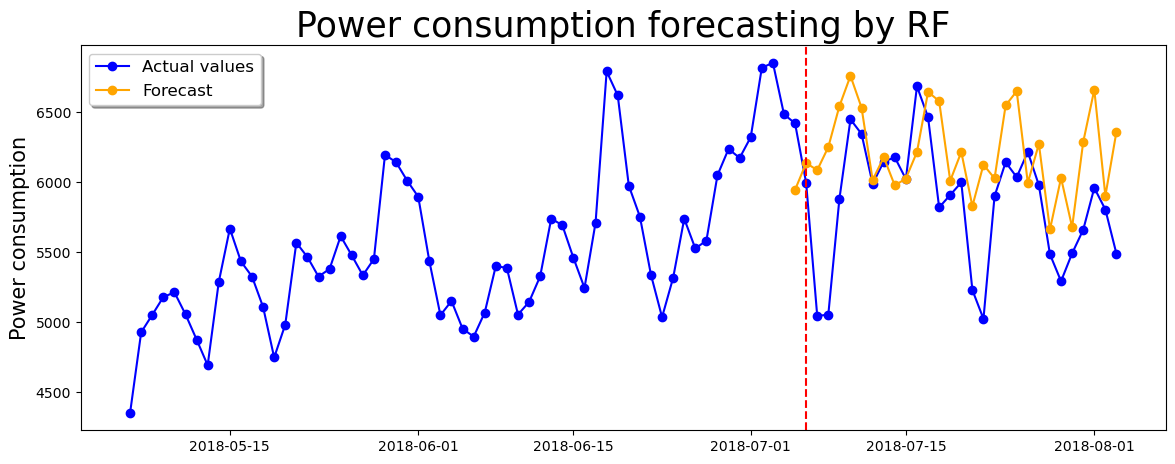

In [128]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_rf.index,future_chk_df_rf.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_rf.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [129]:
MAE_rf_check = mean_absolute_error(daily_data_last_30, future_chk_df_rf)
MAPE_rf_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_rf)*100),3)
RMSE_rf_check=sqrt(mean_squared_error(future_chk_df_rf,daily_data_last_30))
print('RMSE for RF forecast check is:',RMSE_rf_check)
print('MAE for RF forecast check is:',MAE_rf_check)
print('MAPE for RF forecast check is:',MAPE_rf_check)

RMSE for RF forecast check is: 540.8064258418925
MAE for RF forecast check is: 425.20867361111124
MAPE for RF forecast check is: 7.571


### 3.XGB Model

In [130]:
from xgboost import XGBRegressor
final_xg_model = XGBRegressor()
final_xg_model.fit(final_x,y, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [131]:
z=forecast_check_data

for i in range(0,30):
    ck=z[-7:]
    ck=np.array([ck])
    xgb_f_chk=final_xg_model.predict(ck)
    z=np.append(z,xgb_f_chk)
    i=+1
future_pred_XGB=z[-30:]

In [132]:
future_pred_XGB

array([6386.38134766, 5998.98193359, 6202.90625   , 6141.52001953,
       6479.97265625, 6746.92773438, 6316.5234375 , 6392.40673828,
       5769.86962891, 6268.84423828, 5936.80957031, 6349.69824219,
       6694.56835938, 6280.96337891, 6523.03271484, 5496.15039062,
       6297.69677734, 5706.46826172, 6095.37402344, 6397.61474609,
       6126.63671875, 6811.75878906, 5240.66943359, 6527.95703125,
       5231.71679688, 5766.87939453, 6134.2109375 , 6131.51074219,
       7044.73974609, 5238.34423828])

In [133]:
future_chk_xgb = pd.date_range('2018-07-05','2018-08-03', freq='D')
future_chk_df_xgb = pd.DataFrame(index=future_chk_xgb)
future_chk_df_xgb['future_chk_energy'] = future_pred_XGB.tolist()

In [134]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by XGB", fontsize=25)

plt.plot(daily_data1[-90:].index,daily_data1[-90:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_chk_df_xgb.index,future_chk_df_xgb.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(future_chk_df_xgb.index[1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

In [135]:
MAE_xgb_check = mean_absolute_error(daily_data_last_30, future_chk_df_xgb)
MAPE_xgb_check= round((mean_absolute_percentage_error(daily_data_last_30,future_chk_df_xgb)*100),3)
RMSE_xgb_check=sqrt(mean_squared_error(future_chk_df_xgb,daily_data_last_30))
print('RMSE for XGB forecast check is:',RMSE_xgb_check)
print('MAE for XGB forecast check is:',MAE_xgb_check)
print('MAPE for XGB forecast check is:',MAPE_xgb_check)

RMSE for XGB forecast check is: 575.2787936936085
MAE for XGB forecast check is: 448.09221462673605
MAPE for XGB forecast check is: 7.949


## Forecast

In [136]:
from sklearn.ensemble import RandomForestRegressor
final_RF_model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

In [137]:
final_RF_model.fit(final_x,y)

RandomForestRegressor(max_features=3, random_state=1)

In [138]:
daily_data_last_7 = np.array(daily_data['Energy'].tail(7))
daily_data_last_7

array([5485.79166667, 5293.83333333, 5492.70833333, 5660.75      ,
       5959.70833333, 5805.04166667, 5489.        ])

In [139]:
np.savetxt("daily_data_last_7.csv", daily_data_last_7, delimiter=",")

In [140]:
z=daily_data_last_7

for i in range(0,30):
    r=z[-7:]
    r=np.array([r])
    ranf_f=final_RF_model.predict(r)
    z=np.append(z,ranf_f)
    i=+1
future_pred=z[-30:]

In [141]:
future_pred

array([5777.20395833, 5249.90708333, 5517.54375   , 5509.47041667,
       5920.86541667, 5818.44416667, 5537.19208333, 6009.57666667,
       5260.88875   , 5837.40833333, 5370.94083333, 5786.88416667,
       5780.18416667, 5486.65833333, 5994.43625   , 5244.35541667,
       5907.54208333, 5334.28020833, 5746.03854167, 5851.41458333,
       5496.80583333, 5997.78166667, 5215.05708333, 5911.1475    ,
       5261.133125  , 5597.98104167, 5800.98      , 5515.10791667,
       6022.59125   , 5167.75333333])

In [142]:
future = pd.date_range('2018-08-04','2018-09-02', freq='D')
future_df = pd.DataFrame(index=future)

In [143]:
future_df['future_energy'] = future_pred.tolist()

In [144]:
print(future_df)

            future_energy
2018-08-04    5777.203958
2018-08-05    5249.907083
2018-08-06    5517.543750
2018-08-07    5509.470417
2018-08-08    5920.865417
2018-08-09    5818.444167
2018-08-10    5537.192083
2018-08-11    6009.576667
2018-08-12    5260.888750
2018-08-13    5837.408333
2018-08-14    5370.940833
2018-08-15    5786.884167
2018-08-16    5780.184167
2018-08-17    5486.658333
2018-08-18    5994.436250
2018-08-19    5244.355417
2018-08-20    5907.542083
2018-08-21    5334.280208
2018-08-22    5746.038542
2018-08-23    5851.414583
2018-08-24    5496.805833
2018-08-25    5997.781667
2018-08-26    5215.057083
2018-08-27    5911.147500
2018-08-28    5261.133125
2018-08-29    5597.981042
2018-08-30    5800.980000
2018-08-31    5515.107917
2018-09-01    6022.591250
2018-09-02    5167.753333


In [145]:
plt.figure(figsize=(14,5))
plt.title("Power consumption forecasting by RF", fontsize=25)

plt.plot(daily_data1[-365:].index,daily_data1[-365:].values, label='Actual values', color="blue", marker="o")

plt.plot(future_df.index,future_df.values, label='Forecast', color="orange", marker="o")
# plt.fill_between(future_df.index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

plt.axvline(daily_data1.index[-1], color="red", linestyle="--")
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Power consumption', fontsize=15)
plt.show()

## Saving the model

In [151]:
import pickle

In [152]:
filename = 'final_rf_model.pkl'
pickle.dump(final_RF_model, open(filename,'wb'))

In [153]:
pickled_model=pickle.load(open('final_rf_model.pkl','rb'))

In [154]:
pk=pickled_model.predict(X_test)